# The Office (USA) analysis
“Sometimes I’ll start a sentence, and I don’t even know where it’s going. I just hope I find it along the way.”    

“OK, too many different words from coming at me from too many different sentences.”

## Content:
(doesn't work in github, works in nbviewer)
* [Data preparation](#first-bullet)
* [Feature Engineering using script](#second-bullet)
* [What influence rating the most?](#third-bullet)
* [Model to predict rating](#fourth-bullet)

In [1165]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [1166]:
import nltk
from nltk.corpus import stopwords

stop_words = list(set(stopwords.words('english')))

In [1167]:
from wordcloud import WordCloud

In [1168]:
import string
import re
import math

In [1169]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [1170]:
# pd.set_option('display.max_rows', None)

# Data preparation <a class="anchor" id="first-bullet"></a>

there are two source of information:    
schrute database (link), containing all scripts as well as writer and director names for each series,    
and indb database (link) with imdb rating for each episode

The cleaning and preparation of this two datasets should results in one-to-one correspondance of each episode for both datasets.

## Script dataset

source  https://towardsdatascience.com/python-text-analysis-with-the-schrutepy-package-234bc70f3916

### Loading

In [1171]:
from schrutepy import schrutepy 

In [1172]:
script = schrutepy.load_schrute()

In [1173]:
def schrute_prep(df):
    df.drop(columns=['index'], axis=1, inplace=True)
    
    df.rename(columns={'episode_name':'title','text_w_direction':'text_w'},inplace=True)
    
    return df

In [1174]:
script = schrute_prep(script)

In [1175]:
script.head()

,season,episode,title,director,writer,character,text,text_w
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,All right Jim. Your quarterlies look very good...,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,So you've come to the master for guidance? Is ...,So you've come to the master for guidance? Is ...
3,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah."
4,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it's done."


### Drop NaN
script_w   -  there is no NaN in text with writer notes (text_w)   
script     -  there is no NaN in text

In [1176]:
script_w = script.drop(script[script.text_w.isna()].index, axis=0)

In [1177]:
script.dropna(inplace=True)

### Cleaning writer names
there are misprints in writing name

In [1178]:
def clean_writer(df):
    df.loc[df.writer=='Halsted Sullivan;Warren Lieberstein','writer'] = 'Warren Lieberstein;Halsted Sullivan'
    df.loc[df.writer=='Gene Stupnitsky;Lee Eisenberg','writer'] = 'Lee Eisenberg;Gene Stupnitsky'
    df.loc[df.writer=='Michael Schur;Lee Eisenberg;Gene Stupnitsky','writer'] = 'Lee Eisenberg;Gene Stupnitsky;Michael Schur'
#     df[df.writer==] = 
    
    return df

In [1179]:
script = clean_writer(script)

In [1180]:
np.sort(script.writer.unique())

array(['Aaron Shure', 'Allison Silverman', 'Amelie Gillette',
       'Anthony Q. Farrell', 'B.J. Novak', 'Brent Forrester',
       'Brent Forrester;Justin Spitzer', 'Caroline Williams',
       'Carrie Kemper', 'Charlie Grandy', 'Dan Greaney', 'Dan Sterling',
       'Daniel Chun', 'Daniel Chun;Charlie Grandy', 'Graham Wagner',
       'Greg Daniels', 'Greg Daniels;Mindy Kaling', 'Jason Kessler',
       'Jennifer Celotta', 'Jennifer Celotta;Greg Daniels',
       'Jennifer Celotta;Paul Lieberstein', 'Jon Vitti',
       'Jonathan Green;Gabe Miller', 'Jonathan Huges', 'Justin Spitzer',
       'Larry Willmore', 'Lee Eisenberg;Gene Stupnitsky',
       'Lee Eisenberg;Gene Stupnitsky;Michael Schur', 'Lester Lewis',
       'Michael Schur', 'Mindy Kaling', 'Nicki Schwartz-Wright',
       'Owen Ellickson', 'Paul Lieberstein',
       'Paul Lieberstein;Michael Schur', 'Peter Ocko',
       'Ricky Gervais;Stephen Merchant',
       'Ricky Gervais;Stephen Merchant;Greg Daniels', 'Robert Padnick',
       

### Cleaning director names

In [1181]:
def clean_director(df):
    df.loc[df.director=='Greg Daneils','director'] = 'Greg Daniels'
    df.loc[df.director=='Charles McDougal','director'] = 'Charles McDougall'
    df.loc[df.director=='Claire Scanlong','director'] = 'Claire Scanlon'
    df.loc[df.director=='Ken Wittingham','director'] = 'Ken Whittingham'
    df.loc[df.director=='Paul Lieerstein','director'] = 'Paul Lieberstein'
    df.loc[df.director=='Gene Stupnitsky;Lee Eisenberg','director'] = 'Lee Eisenberg;Gene Stupnitsky'
    return df

In [1182]:
script = clean_director(script)

In [1183]:
np.sort(script.director.unique())

array(['Alex Hardcastle', 'Amy Heckerling', 'Asaad Kelada', 'B.J. Novak',
       'Brent Forrester', 'Brian Baumgartner', 'Bryan Cranston',
       'Bryan Gordon', 'Charles McDougall', 'Charlie Grandy',
       'Claire Scanlon', 'Craig Zisk', 'Daniel Chun', 'Danny Leiner',
       'David Rogers', 'Dean Holland', 'Dennie Gordon', 'Ed Helms',
       'Eric Appel', 'Greg Daniels', 'Harold Ramis', 'J.J. Abrams',
       'Jason Reitman', 'Jeffrey Blitz', 'Jennifer Celotta',
       'Jesse Peretz', 'John Krasinski', 'John Scott', 'Jon Favreau',
       'Joss Whedon', 'Julian Farino', 'Kelly Cantley-Kashima',
       'Ken Kwapis', 'Ken Whittingham', 'Lee Eisenberg;Gene Stupnitsky',
       'Lee Kirk', 'Marc Webb', 'Matt Sohn', 'Michael Spiller',
       'Miguel Arteta', 'Mindy Kaling', 'Paul Feig', 'Paul Lieberstein',
       'Rainn Wilson', 'Randall Einhorn', 'Reginald Hudlin',
       'Rodman Flender', 'Roger Nygard', 'Seth Gordon',
       'Seth Gordon;Harold Ramis', 'Stephen Merchant', 'Steve Carell',


### Creating database with episode properties using script database

In [1184]:
def author_df(df):
    db = {}
    count = 0
    seasons = df.season.unique()
    
    for season in seasons:
        episodes = df[df.season==season].episode.unique()
        
        for episode in episodes:
            title = df[(df.season==season) & (df.episode==episode)].title.values[0]
            director = df[(df.season==season) & (df.episode==episode)].director.values[0]
            writer = df[(df.season==season) & (df.episode==episode)].writer.values[0]
            
            db[count] = {'season':season,'episode':episode,
                         'title':title,'director':director,
                        'writer':writer}
        
            count += 1
    
    return pd.DataFrame(db).transpose()

In [1185]:
author = author_df(script)

In [1186]:
author.head()

,season,episode,title,director,writer
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein
3,1,4,The Alliance,Bryan Gordon,Michael Schur
4,1,5,Basketball,Greg Daniels,Greg Daniels


## Database with episode rating

In [1187]:
rate = pd.read_csv('the_office_imdb.csv')

In [1188]:
rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season             188 non-null    int64  
 1   episode_num        188 non-null    int64  
 2   title              188 non-null    object 
 3   original_air_date  188 non-null    object 
 4   imdb_rating        188 non-null    float64
 5   total_votes        188 non-null    int64  
 6   desc               188 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 10.4+ KB


In [1189]:
rate.rename(columns={'episode_num':'episode','total_votes':'votes','imdb_rating':'rating'},inplace=True)

In [1190]:
rate.head()

,season,episode,title,original_air_date,rating,votes,desc
0,1,1,Pilot,2005-03-24,7.4,7006,The premiere episode introduces the boss and s...
1,1,2,Diversity Day,2005-03-29,8.3,6902,Michael's off color remark puts a sensitivity ...
2,1,3,Health Care,2005-04-05,7.7,5756,Michael leaves Dwight in charge of picking the...
3,1,4,The Alliance,2005-04-12,8.0,5579,"Just for a laugh, Jim agrees to an alliance wi..."
4,1,5,Basketball,2005-04-19,8.4,6183,Michael and his staff challenge the warehouse ...


### Check correspondance of auhtor and rate  episode numeration

In [1191]:
len(author.title)

186

In [1192]:
len(rate.title)

188

In [1193]:
def compare_db(db1, db2):
    count = 0
    for season in range(1,10):
            episodes = np.sort(db1[db1.season==season].episode.unique())

            for episode in episodes: 
                print()
                print(season, episode)
                print(db1[(db1.season==season) & (db1.episode==episode)].title.values)

                if len(db2[(db2.season==season) & (db2.episode==episode)]) > 0:
                    print(db2[(author.season==season) & (db2.episode==episode)].title.values)
                else:
                    print('---')
                    count += 1

    print(f'{count} mismatchs')

In [1194]:
compare_db(rate, author)


1 1
['Pilot']
['Pilot']

1 2
['Diversity Day']
['Diversity Day']

1 3
['Health Care']
['Health Care']

1 4
['The Alliance']
['The Alliance']

1 5
['Basketball']
['Basketball']

1 6
['Hot Girl']
['Hot Girl']

2 1
['The Dundies']
['The Dundies']

2 2
['Sexual Harassment']
['Sexual Harassment']

2 3
['Office Olympics']
['Office Olympics']

2 4
['The Fire']
['The Fire']

2 5
['Halloween']
['Halloween']

2 6
['The Fight']
['The Fight']

2 7
['The Client']
['The Client']

2 8
['Performance Review']
['Performance Review']

2 9
['E-Mail Surveillance']
['E-Mail Surveilance']

2 10
['Christmas Party']
['Christmas Party']

2 11
['Booze Cruise']
['Booze Cruise']

2 12
['The Injury']
['The Injury']

2 13
['The Secret']
['The Secret']

2 14
['The Carpet']
['The Carpet']

2 15
['Boys and Girls']
['Boys & Girls']

2 16
["Valentine's Day"]
["Valentine's Day"]

2 17
["Dwight's Speech"]
["Dwight's Speech"]

2 18
['Take Your Daughter to Work Day']
['Take Your Daughter to Work Day']

2 19
["Michael's Birt

To merge script and rate database I should be shuare that episode numeration are the same in both databases. It is clearly not the case.

In rate double episode enumerated as one,
In script (and author as well), episode following double has +1 numeration (each double episode use two counts)    

So. I should shift numeration in rate after each double episode

### Mark double episdoe

In [1195]:
# find all episodes with Part1&2 in title
double_titles = []
for name in script.title.value_counts().index:
    if "Parts 1&2" in name:
        double_titles.append(name.replace(' (Parts 1&2)',''))
double_titles

['The Delivery',
 'Classy Christmas',
 'Niagara',
 'Dunder Mifflin Infinity',
 'Launch Party',
 'Goodbye, Toby',
 'The Job',
 'Weight Loss',
 'Search Committee',
 'A Benihana Christmas',
 'Fun Run',
 'Money',
 'Stress Relief']

addition [Wikipedia](https://en.wikipedia.org/wiki/List_of_The_Office_(American_TV_series)_episodes)

In [1196]:
double_titles = double_titles + ['A.A.R.M.',"Finale"]

In [1197]:
rate['double'] = 0

for name in double_titles:
    rate.loc[rate.title==name,'double']=1

In [1198]:
rate[rate.double==1]

,season,episode,title,original_air_date,rating,votes,desc,double
37,3,10,A Benihana Christmas,2006-12-14,8.8,4791,Trouble among the members of the party plannin...,1
50,3,23,The Job,2007-05-17,9.3,5482,"Michael appoints Dwight as regional manager, a...",1
51,4,1,Fun Run,2007-09-27,8.8,5065,Michael accidentally runs over Meridith in the...,1
52,4,2,Dunder Mifflin Infinity,2007-10-04,8.3,4174,Michael feels threatened when Ryan returns to ...,1
53,4,3,Launch Party,2007-10-11,8.4,4064,The Dunder Mifflin Infinity website is launchi...,1
54,4,4,Money,2007-10-18,8.7,4377,"As Jan renovates the condo, Michael confronts ...",1
64,4,14,"Goodbye, Toby",2008-05-15,9.4,5577,Michael throws an extravagant going-away party...,1
65,5,1,Weight Loss,2008-09-25,8.8,4597,Michael tries to motivate the Scranton branch ...,1
77,5,13,Stress Relief,2009-02-01,9.7,11895,Dwight's too-realistic fire alarm gives Stanle...,1
127,7,11,Classy Christmas,2010-12-09,9.0,4190,Michael throws an elaborate Christmas party to...,1


### Shift numeration in rate

In [1199]:
def shift_numeration(db):
    db['episode_shifted'] = db['episode']
    
    for season in range(1,10):
        episodes = np.sort(db[db.season==season].episode.unique())

        for episode in episodes: 

            if db[(db.season==season) & (db.episode==episode)].double.values==1:
                for following in range(episode + 1, max(episodes)+1):
                    old_val = db[(db.season==season) & (db.episode==following)].episode_shifted
                    db.loc[(db.season==season) & (db.episode==following),'episode_shifted'] = old_val + 1

    return db

In [1200]:
rate=shift_numeration(rate)

In [1201]:
rate.drop(columns=['episode'],axis=1,inplace=True)

In [1202]:
rate.rename(columns={'episode_shifted':'episode'},inplace=True)

### Delete one of Niagara and The Delivery  episode
those two double series are not doubled in imdb for some reason. Since in schrute dataset they are merged, i will merge them. Since this double series have almost the same imdb rating,the merging will not introduce significant inaccuracies.  and compute wieighted average imdb rating. 

i will calculate rate as weighted average

In [1203]:
def w_average(df, word):
    rates = df[df.title.str.lower().str.contains(word)].rating.values
    votes = df[df.title.str.lower().str.contains(word)].votes.values

    av = np.dot(rates, votes)/sum(votes)
    print(rates, votes, round(av,1))
    return round(av,1) 

#### Niagara

In [1204]:
w_average(rate, 'niagara')

[9.4 9.5] [6277 5122] 9.4


9.4

the new rating is the same as rating for first series 

In [1205]:
rate.drop(rate[rate.title=='Niagara: Part 2'].index, axis=0,inplace=True)
rate.loc[rate.title.str.lower().str.contains('niagara'),'title'] = 'Niagara'
rate.loc[rate.title.str.lower().str.contains('niagara'),'double'] = 1

In [1206]:
rate[rate.title.str.lower().str.contains('niagara')]

,season,title,original_air_date,rating,votes,desc,double,episode
94,6,Niagara,2009-10-08,9.4,6277,The Office travels to Niagara Falls to celebra...,1,4


#### Delivery

In [1207]:
new_rate = w_average(rate, 'delivery')

[8.4 8.5] [3438 3445] 8.5


In [1208]:
rate.drop(rate[rate.title=='The Delivery: Part 2'].index, axis=0,inplace=True)

rate.loc[rate.title.str.lower().str.contains('delivery'),'double'] = 1
rate.loc[rate.title.str.lower().str.contains('delivery'),'title'] = 'The Delivery'
rate.loc[rate.title.str.lower().str.contains('delivery'),'rating'] = new_rate

In [1209]:
rate[rate.title.str.lower().str.contains('delivery')]

,season,title,original_air_date,rating,votes,desc,double,episode
107,6,The Delivery,2010-03-04,8.5,3438,Pam goes into labor and Jim is ready to take h...,1,17


#### Compare enumration again

In [1210]:
compare_db(rate, author)


1 1
['Pilot']
['Pilot']

1 2
['Diversity Day']
['Diversity Day']

1 3
['Health Care']
['Health Care']

1 4
['The Alliance']
['The Alliance']

1 5
['Basketball']
['Basketball']

1 6
['Hot Girl']
['Hot Girl']

2 1
['The Dundies']
['The Dundies']

2 2
['Sexual Harassment']
['Sexual Harassment']

2 3
['Office Olympics']
['Office Olympics']

2 4
['The Fire']
['The Fire']

2 5
['Halloween']
['Halloween']

2 6
['The Fight']
['The Fight']

2 7
['The Client']
['The Client']

2 8
['Performance Review']
['Performance Review']

2 9
['E-Mail Surveillance']
['E-Mail Surveilance']

2 10
['Christmas Party']
['Christmas Party']

2 11
['Booze Cruise']
['Booze Cruise']

2 12
['The Injury']
['The Injury']

2 13
['The Secret']
['The Secret']

2 14
['The Carpet']
['The Carpet']

2 15
['Boys and Girls']
['Boys & Girls']

2 16
["Valentine's Day"]
["Valentine's Day"]

2 17
["Dwight's Speech"]
["Dwight's Speech"]

2 18
['Take Your Daughter to Work Day']
['Take Your Daughter to Work Day']

2 19
["Michael's Birt

numeration matchs now.

## Combining rating and author information in one data frame

In [1211]:
author.head(1)

,season,episode,title,director,writer
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels


In [1212]:
rate.head(1)

,season,title,original_air_date,rating,votes,desc,double,episode
0,1,Pilot,2005-03-24,7.4,7006,The premiere episode introduces the boss and s...,0,1


In [1213]:
print(len(rate), len(author))

186 186


In [1214]:
author.reset_index(inplace=True)
rate.reset_index(inplace=True)

In [1215]:
df = rate.copy(deep=True)

In [1216]:
df['writer'] = author.writer
df['director'] = author.director
df['season_x'] = author.season
df['episode_x'] = author.episode

double check the match between numeration

In [1217]:
for index in df.index:
    
    if df[df.index==index].season.values != df[df.index==index].season_x.values:
        print(f'mismatch: index={index}')
    
    if df[df.index==index].episode.values != df[df.index==index].episode_x.values:
        print(f'mismatch: index={index}')

### Delete  some columns

In [1218]:
df.drop(columns=['desc','index','season_x','episode_x'],inplace=True)

### Normilise votes

In [1219]:
total = df.votes.sum()
df['votes_norm'] = df.votes/total
print(f"total votes is {total}, total after normalistaion is {df.votes_norm.sum()}")

total votes is 765842, total after normalistaion is 1.0


## Cleaning of episode information

### month

In [1220]:
df['date'] = pd.to_datetime(df['original_air_date'])

In [1221]:
df['month'] = df['date'].apply(lambda date: date.month)

In [1222]:
df.drop(columns=['original_air_date','date'],inplace=True)

### Make director and writer as categorical

#### writer

In [1223]:
writers = ['B.J. Novak', 'Mindy Kaling','Gene Stupnitsky', 'Justin Spitzer', 'Brent Forrester',
       'Jennifer Celotta', 'Michael Schur','Warren Lieberstein','Halsted Sullivan', 'Aaron Shure', 'Daniel Chun',
       'Robert Padnick', 'Owen Ellickson', 'Carrie Kemper','Allison Silverman', 'Steve Hely', 'Lester Lewis', 'Steve Carell',
       'Dan Greaney', 'Jonathan Green','Gabe Miller', 'Anthony Q. Farrell',
       'Graham Wagner', 'Dan Sterling', 'Amelie Gillette','Nicki Schwartz-Wright', 'Jon Vitti',
       'Paul Lieberstein','Ryan Koh', 'Tim McAuliffe','Greg Daniels', 'Ricky Gervais','Stephen Merchant','Lee Eisenberg','Caroline Williams',
       'Jason Kessler', 'Peter Ocko', 'Charlie Grandy',
       'Larry Willmore', 'Jonathan Huges']

In [1224]:
for writer in writers:
    writer_no_space = writer.replace(' ',"_")
    df['writer_' + writer_no_space] = 0
    
    for season in range(1,10):
        episodes = np.sort(df[df.season==season].episode.unique())

        for episode in episodes: 
            if writer in df[(df.season==season) & (df.episode==episode)].writer.values[0]:
                df.loc[(df.season==season) & (df.episode==episode),['writer_' + writer_no_space]] = 1

transform list with writer names to list with column name for writer

In [1225]:
writers = ['writer_' + writer.replace(' ','_') for writer in writers]

In [1226]:
df[np.insert(writers,0,'writer')].iloc[:10]

,writer,writer_B.J._Novak,writer_Mindy_Kaling,writer_Gene_Stupnitsky,writer_Justin_Spitzer,writer_Brent_Forrester,writer_Jennifer_Celotta,writer_Michael_Schur,writer_Warren_Lieberstein,writer_Halsted_Sullivan,...,writer_Greg_Daniels,writer_Ricky_Gervais,writer_Stephen_Merchant,writer_Lee_Eisenberg,writer_Caroline_Williams,writer_Jason_Kessler,writer_Peter_Ocko,writer_Charlie_Grandy,writer_Larry_Willmore,writer_Jonathan_Huges
0,Ricky Gervais;Stephen Merchant;Greg Daniels,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
1,B.J. Novak,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Paul Lieberstein,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Michael Schur,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Greg Daniels,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,Mindy Kaling,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Mindy Kaling,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,B.J. Novak,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Michael Schur,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,B.J. Novak,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### director

In [1227]:
directors = ['Randall Einhorn', 'Greg Daniels', 'Paul Feig', 'Ken Kwapis',
       'Jeffrey Blitz', 'Ken Whittingham', 'David Rogers', 'Matt Sohn',
       'Charles McDougall', 'Paul Lieberstein', 'B.J. Novak',
       'Brent Forrester', 'Tucker Gates', 'Troy Miller', 'Harold Ramis',
       'Rainn Wilson', 'John Krasinski', 'Steve Carell', 'Jennifer Celotta',
       'Mindy Kaling', 'Ed Helms', 'Julian Farino',
       'Lee Eisenberg','Gene Stupnitsky', 'Victor Nelli Jr.', 'Joss Whedon',
       'Claire Scanlon', 'Dean Holland', 'Rodman Flender', 'Dennie Gordon',
       'Jason Reitman', 'Bryan Gordon', 'Charlie Grandy', 'Miguel Arteta',
       'Jesse Peretz', 'Daniel Chun', 'Eric Appel',
       'Marc Webb', 'Roger Nygard', 'Lee Kirk', 'Amy Heckerling', 'John Scott',
       'Seth Gordon', 'Stephen Merchant', 'Bryan Cranston', 'Reginald Hudlin',
       'Craig Zisk', 'Brian Baumgartner', 'J.J. Abrams', 'Alex Hardcastle',
       'Kelly Cantley-Kashima', 'Michael Spiller', 'Danny Leiner',
       'Asaad Kelada', 'Jon Favreau']

In [1228]:
for director in directors:
    director_no_space = director.replace(' ','_')
    df['director_' + director_no_space] = 0
    
    for season in range(1,10):
        episodes = np.sort(df[df.season==season].episode.unique())

        for episode in episodes: 
            if director in df[(df.season==season) & (df.episode==episode)].director.values[0]:
                df.loc[(df.season==season) & (df.episode==episode), 'director_' + director_no_space] = 1

transform director list

In [1229]:
directors = ['director_' + director.replace(' ','_') for director in directors]

In [1230]:
df[np.insert(directors,0,'director')].iloc[:10]

,director,director_Randall_Einhorn,director_Greg_Daniels,director_Paul_Feig,director_Ken_Kwapis,director_Jeffrey_Blitz,director_Ken_Whittingham,director_David_Rogers,director_Matt_Sohn,director_Charles_McDougall,...,director_Reginald_Hudlin,director_Craig_Zisk,director_Brian_Baumgartner,director_J.J._Abrams,director_Alex_Hardcastle,director_Kelly_Cantley-Kashima,director_Michael_Spiller,director_Danny_Leiner,director_Asaad_Kelada,director_Jon_Favreau
0,Ken Kwapis,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ken Kwapis,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ken Whittingham,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bryan Gordon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Greg Daniels,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Amy Heckerling,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Greg Daniels,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Ken Kwapis,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Paul Feig,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Ken Kwapis,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Delete writer and director columns

In [1231]:
df.drop(columns=['writer','director'],inplace=True)

# Feature engineering  using script
<a class="anchor" id="second-bullet"></a>

analysing script information to create feature for each episode    
this features will be used to predict episode rating

In [1232]:
df.head(1)

,season,title,rating,votes,double,episode,votes_norm,month,writer_B.J._Novak,writer_Mindy_Kaling,...,director_Reginald_Hudlin,director_Craig_Zisk,director_Brian_Baumgartner,director_J.J._Abrams,director_Alex_Hardcastle,director_Kelly_Cantley-Kashima,director_Michael_Spiller,director_Danny_Leiner,director_Asaad_Kelada,director_Jon_Favreau
0,1,Pilot,7.4,7006,0,1,0.009148,3,0,0,...,0,0,0,0,0,0,0,0,0,0


## Functions to work with text

In [1233]:
# returns bag of words
def prepare_text(text, stop=True):
    words = nltk.word_tokenize(text)

    words=[word.lower() for word in words if word.isalpha()]
    
    if stop:
        words = [w for w in words if not w in stop_words]
    
    return words

In [1234]:
def dispersion_plot(text, words, ignore_case=False, title="Lexical Dispersion Plot"):
    """
    Generate a lexical dispersion plot.

    :param text: The source text
    :type text: list(str) or enum(str)
    :param words: The target words
    :type words: list of str
    :param ignore_case: flag to set if case should be ignored when searching text
    :type ignore_case: bool
    
    https://www.nltk.org/_modules/nltk/draw/dispersion.html
    """

    try:
        from matplotlib import pylab
    except ImportError as e:
        raise ValueError(
            "The plot function requires matplotlib to be installed."
            "See https://matplotlib.org/"
        ) from e

    text = list(text)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
    else:
        words_to_comp = words
        text_to_comp = text

    points = [
        (x, y)
        for x in range(len(text_to_comp))
        for y in range(len(words_to_comp))
        if text_to_comp[x] == words_to_comp[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    pylab.plot(x, y, "b|", scalex=0.1)
    pylab.yticks(list(range(len(words))), words, color="b")
    pylab.ylim(-1, len(words))
    pylab.title(title)
    pylab.xlabel("Word Offset")
    pylab.show()

## Prepare bag of words

In [1235]:
text_row_all = ' '.join( word for word in script.text.values)

In [1236]:
bow_all = prepare_text(text_row_all,stop=False)
bow_without_stop = prepare_text(text_row_all,stop=True)

## Count words in episode
all words (stop words are not deleted) for each episdoe

In [1237]:
df['words'] = 0

for season in range(1,10):
    episodes = np.sort(df[df.season==season].episode.unique())

    for episode in episodes: 
        text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode)].text)
        
        text = prepare_text(text_row,stop=False)
        
        df.loc[(df.season==season) & (df.episode==episode),'words'] = len(text)      
        

<AxesSubplot:xlabel='words', ylabel='Count'>

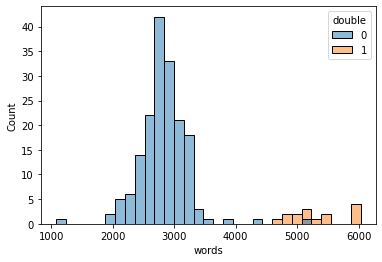

In [1238]:
sns.histplot(data=df, x='words', hue='double')

one double episode was missed

In [1239]:
df[(df.words > 5000) & (df.double==0)]

,season,title,rating,votes,double,episode,votes_norm,month,writer_B.J._Novak,writer_Mindy_Kaling,...,director_Craig_Zisk,director_Brian_Baumgartner,director_J.J._Abrams,director_Alex_Hardcastle,director_Kelly_Cantley-Kashima,director_Michael_Spiller,director_Danny_Leiner,director_Asaad_Kelada,director_Jon_Favreau,words
178,9,Moving On,8.0,3065,0,16,0.004002,2,0,0,...,0,0,0,0,0,0,0,0,1,5209


episode "Moving one" has double running time (41 min), so I will mark it as double

In [1240]:
df.loc[df.title=='Moving On','double'] = 1

 ## Does double series have higher rating?

In [1241]:
round(df[df.double==0].words.mean())

2812

In [1242]:
round(df[df.double==0].words.median())

2825

In [1243]:
round(df[df.double==1].words.mean())

5329

In [1244]:
round(df[df.double==1].words.median())

5208

In [1245]:
df[df.words<1500][['season','episode','title','double','rating','votes','words']]

,season,episode,title,double,rating,votes,words
103,6,14,The Banker,0,6.8,4380,1080


In [1246]:
df[(df.double==0)&(df.words>4000)][['season','episode','title','double','rating','votes','words']]

,season,episode,title,double,rating,votes,words
183,9,21,Livin' the Dream,0,9.1,4448,4309


## How much words each character says in episode

normalized by words in each episode

most talkative character (number of replicas )

In [1247]:
script.character.value_counts()[:10]

Michael    10877
Dwight      6801
Jim         6268
Pam         5006
Andy        3739
Angela      1551
Kevin       1551
Erin        1431
Oscar       1359
Ryan        1191
Name: character, dtype: int64

In [1248]:
characters = script.character.value_counts()[:30].index

calculating number of words each character said in episode,     
'Name_words' - in percent of total words in the episode (normilised by number of words in the episode)    
'Name_words_total' - just total wnumber of words

In [1249]:
for person in characters:
    df[person + '_words'] = np.nan
    df[person + '_words_total'] = np.nan
    
    for season in range(1,10):
        episodes = np.sort(df[df.season==season].episode.unique())

        for episode in episodes: 
            text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode) & (script.character==person)].text)
            
            # do not delete stop words
            text = prepare_text(text_row, stop=False)
            
            # total words in the episode
            total_words = df[(df.season==season) & (df.episode==episode)].words
            df.loc[(df.season==season) & (df.episode==episode),[person + '_words_total']] = len(text)
            df.loc[(df.season==season) & (df.episode==episode),[person + '_words']] = 100*len(text)/total_words

In [1250]:
characters_words = [name+'_words' for name in characters]

### Who talks more

In [1251]:
import matplotlib
print(matplotlib.__version__)

3.3.2


[Text(0.5, 1.0, 'Number of words character said during all episodes'),
 Text(0.5, 0, 'words')]

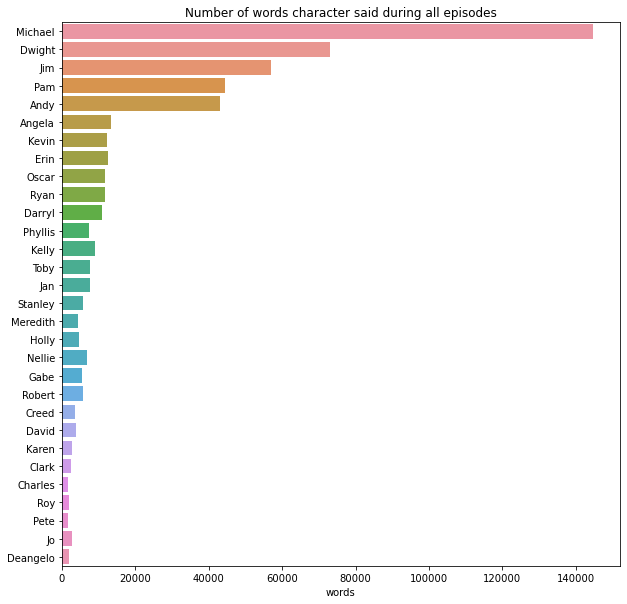

In [1252]:
characters_words_total = [name+'_total' for name in characters_words]

fig = plt.figure(figsize=(10,10))
ax = sns.barplot(y=characters, x=df[characters_words_total].sum())
# ax.bar_label(ax.containers[0])
ax.set(title='Number of words character said during all episodes',xlabel='words')

<ipython-input-1253-e178d1b02939>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


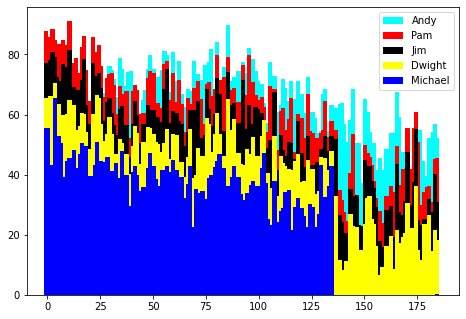

In [1253]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(df.index, df.apply(lambda x: x['Michael_words'] + x['Dwight_words'] + x['Jim_words'] + x['Pam_words'] + x['Andy_words'],axis=1),color='cyan')
ax.bar(df.index, df.apply(lambda x: x['Michael_words'] + x['Dwight_words'] + x['Jim_words'] + x['Pam_words'],axis=1),color='red')
ax.bar(df.index, df.apply(lambda x: x['Michael_words'] + x['Dwight_words'] + x['Jim_words'],axis=1),color='black')
ax.bar(df.index, df.apply(lambda x: x['Michael_words'] + x['Dwight_words'],axis=1),color='yellow')
ax.bar(df.index, df.Michael_words,color='blue')

plt.tight_layout()
plt.legend(['Andy','Pam','Jim','Dwight','Michael'])

# chancge width of bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * 1)

change_width(ax, 2)

In [1254]:
seasons = np.linspace(1,9,9)

df_tmp = {}
for season in seasons:
    total_words = df[df.season==season].words.sum()
    
    
    df_tmp.update({season:{ 'Michael': 100*df[df.season==season].Michael_words_total.sum()/total_words,
                            'Dwight': 100*df[df.season==season].apply(lambda x: x['Michael_words_total'] + x['Dwight_words_total'],axis=1).sum()/total_words,
                            'Jim' : 100*df[df.season==season].apply(lambda x: x['Michael_words_total'] + x['Dwight_words_total'] +  x['Jim_words_total'],axis=1).sum()/total_words,
                            'Pam': 100*df[df.season==season].apply(lambda x: x['Michael_words_total'] + x['Dwight_words_total'] + x['Jim_words_total'] + x['Pam_words_total'],axis=1).sum()/total_words,
                            'Andy': 100*df[df.season==season].apply(lambda x: x['Michael_words_total'] + x['Dwight_words_total'] + x['Jim_words_total'] + x['Pam_words_total'] + x['Andy_words_total'],axis=1).sum()/total_words,
                           'Angela': 100*df[df.season==season].apply(lambda x: x['Michael_words_total'] + x['Dwight_words_total'] + x['Jim_words_total'] + x['Pam_words_total'] + x['Andy_words_total'] + x['Angela_words_total'],axis=1).sum()/total_words,
                           'Kevin': 100*df[df.season==season].apply(lambda x: x['Michael_words_total'] + x['Dwight_words_total'] + x['Jim_words_total'] + x['Pam_words_total'] + x['Andy_words_total'] + x['Angela_words_total'] + x['Kevin_words_total'],axis=1).sum()/total_words,
                            'Erin': 100*df[df.season==season].apply(lambda x: x['Michael_words_total'] + x['Dwight_words_total'] + x['Jim_words_total'] + x['Pam_words_total'] + x['Andy_words_total'] + x['Angela_words_total'] + x['Kevin_words_total'] + x['Erin_words_total'],axis=1).sum()/total_words

                          }})
df_tmp = pd.DataFrame(df_tmp).transpose()


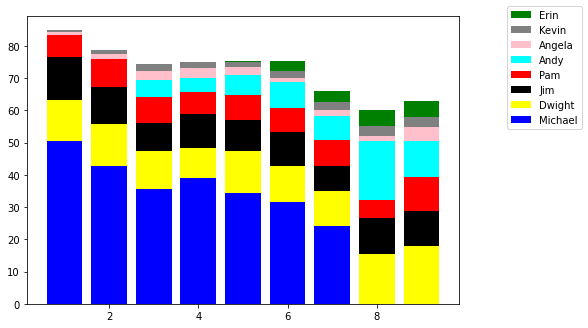

In [1255]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.bar(df_tmp.index,df_tmp.Erin,color='green')
ax.bar(df_tmp.index,df_tmp.Kevin,color='gray')
ax.bar(df_tmp.index,df_tmp.Angela,color='pink')
ax.bar(df_tmp.index,df_tmp.Andy,color='cyan')
ax.bar(df_tmp.index,df_tmp.Pam,color='red')
ax.bar(df_tmp.index,df_tmp.Jim,color='black')
ax.bar(df_tmp.index,df_tmp.Dwight,color='yellow')
ax.bar(df_tmp.index,df_tmp.Michael,color='blue')

plt.legend(['Erin','Kevin','Angela','Andy','Pam','Jim','Dwight','Michael'],bbox_to_anchor=(1.1, 1.05))
plt.show()

Michael words decsrease almost lineraly with time   
after Michael leaving, Dwight and Andy took his time

<AxesSubplot:>

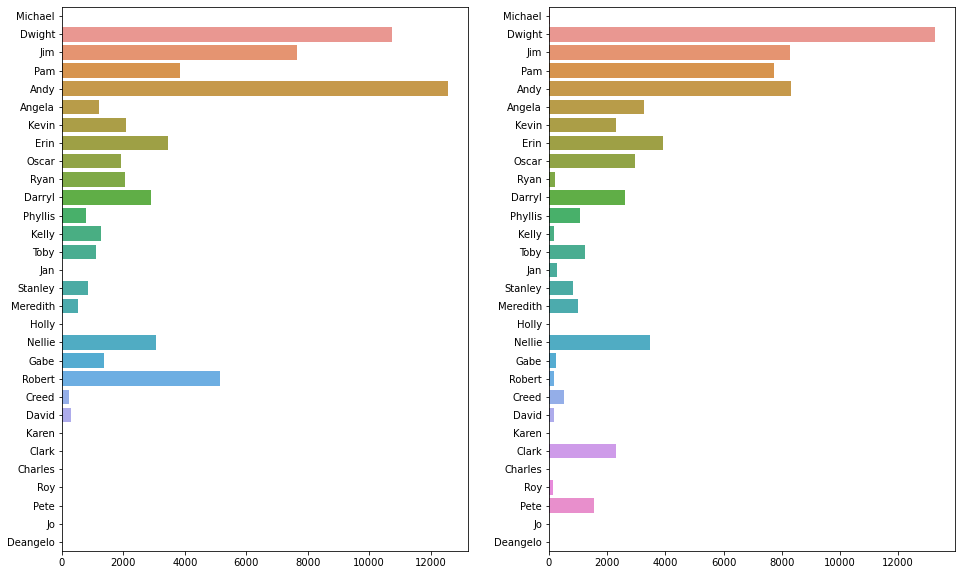

In [1256]:
fig,ax  = plt.subplots(figsize=(16,10),nrows=1, ncols=2)
sns.barplot(y=characters, x=df[df.season==8][characters_words_total].sum(),ax=ax[0])
sns.barplot(y=characters, x=df[df.season==9][characters_words_total].sum(),ax=ax[1])
# ax.set(title='Number of words character said during all episodes',xlabel='words')

### Correlation of words number for characters

<AxesSubplot:>

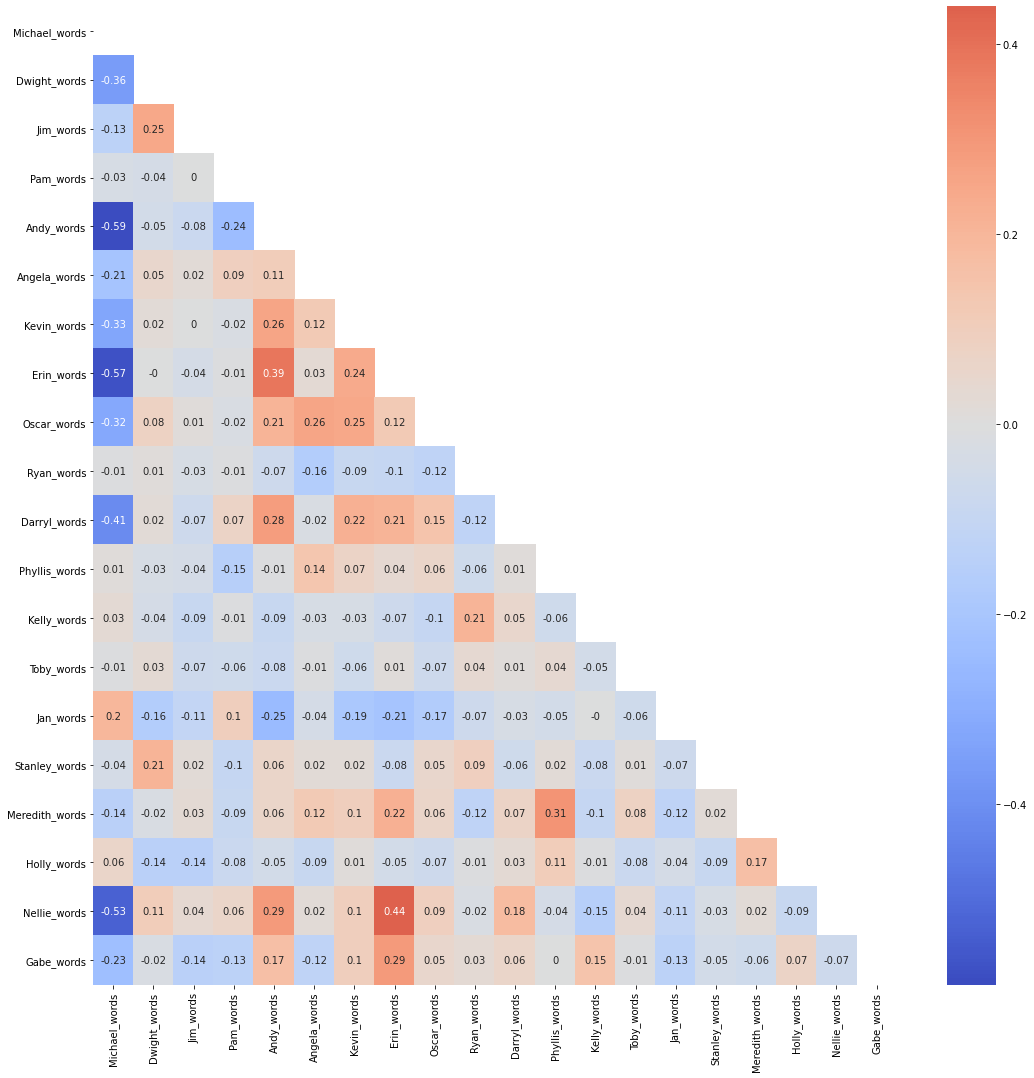

In [1257]:
df_tmp = df[characters_words[:20]]
corr = df_tmp.corr().round(2)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(18,18))
sns.heatmap(corr, cmap='coolwarm', mask=mask, center=0,annot=True)

How Dwight and Michael words evolve through seasons

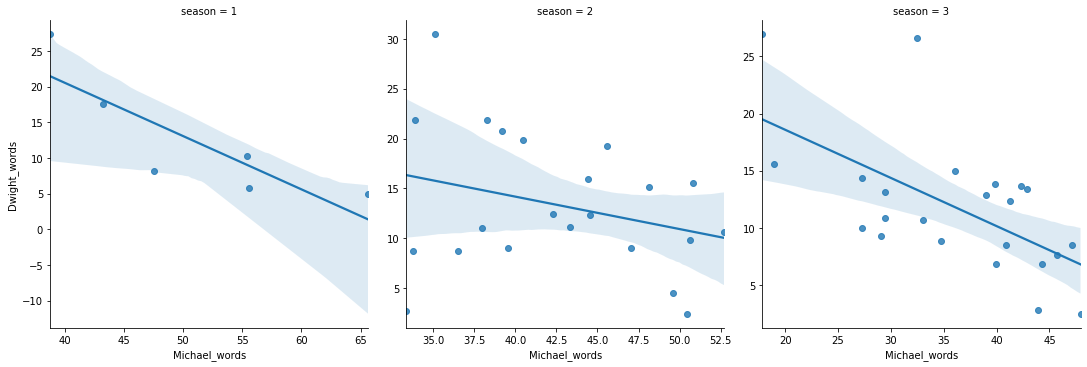

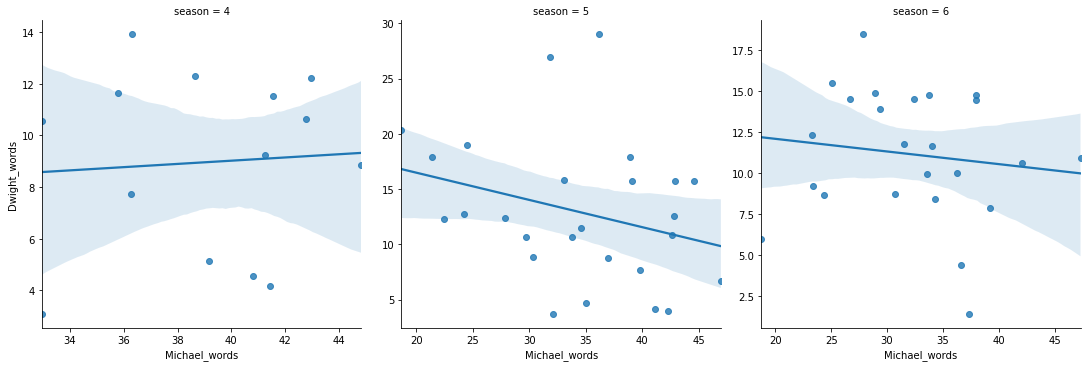

In [1258]:
sns.lmplot(data=df[df.season < 4],x='Michael_words', y='Dwight_words',col='season',sharex=False,sharey=False)
sns.lmplot(data=df[(df.season >= 4) & (df.season < 7)],x='Michael_words', y='Dwight_words',col='season',sharex=False, sharey=False)

## One person talking about the other
normilised by number of words of the character

In [1259]:
def person_about_the_other(df, who, list_about_whom):
    for name in list_about_whom:
        df[who + '_about_' + name] = 0
    
    
    for season in range(1,10):
        episodes = np.sort(df[df.season==season].episode.unique())

        for episode in episodes: 
            text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode) & (script.character=='Jim')].text)
            text = prepare_text(text_row, stop=True)

            # calculate how much words character says in this episode:  char_words * words / 100
            person_words =  df[(df.season==season) & (df.episode==episode)].words * df[(df.season==season) & (df.episode==episode)][who + '_words'] /100
            
            if person_words.values != 0: # to avoid dividing by zero
                for name in list_about_whom:
                    df.loc[(df.season==season) & (df.episode==episode),[who + '_about_' + name]] = 100*text.count(name.lower())/person_words

    return df

In [1260]:
df = person_about_the_other(df,'Jim',['Pam','Dwight'])
df = person_about_the_other(df,'Pam',['Jim','Michael'])

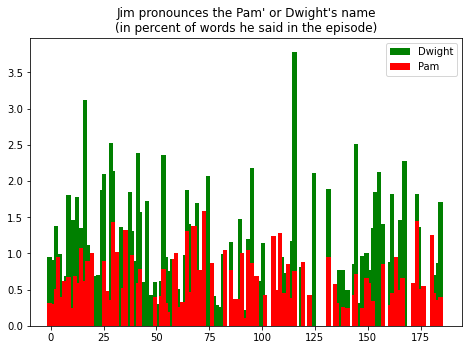

In [1261]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.bar(df.index,df.Jim_about_Pam+df.Jim_about_Dwight,color='green')
ax.bar(df.index,df.Jim_about_Pam,color='red')

plt.title("Jim pronounces the Pam' or Dwight's name\n(in percent of words he said in the episode)")
plt.legend(['Dwight','Pam'])
# change width of bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * 1)

change_width(ax, 2)



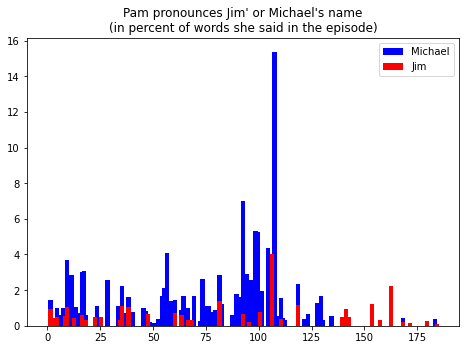

In [1262]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.bar(df.index,df.Pam_about_Jim + df.Pam_about_Michael,color='blue')
ax.bar(df.index,df.Pam_about_Jim,color='red')

plt.title("Pam pronounces Jim' or Michael's name\n(in percent of words she said in the episode)")
plt.legend(['Michael','Jim'])
# change width of bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * 1)

change_width(ax, 2)

for Michael_about_Holly  will use register sensititvity to avoid counting holly as Holly

In [1263]:
df['Michael_about_Jan'] = 0
df['Michael_about_Holly'] = 0

for season in range(1,10):
    episodes = np.sort(df[df.season==season].episode.unique())

    for episode in episodes: 
        text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode) & (script.character=='Michael')].text)

#         text = prepare_text(text_row, stop=True)
        text = nltk.word_tokenize(text_row)
        
        tot_words =  df[(df.season==season) & (df.episode==episode)].words * df[(df.season==season) & (df.episode==episode)].Michael_words /100
        
        if tot_words.values != 0:
            df.loc[(df.season==season) & (df.episode==episode),['Michael_about_Jan']] = 100*text.count('Jan')/tot_words
            df.loc[(df.season==season) & (df.episode==episode),['Michael_about_Holly']] = 100*text.count('Holly')/tot_words

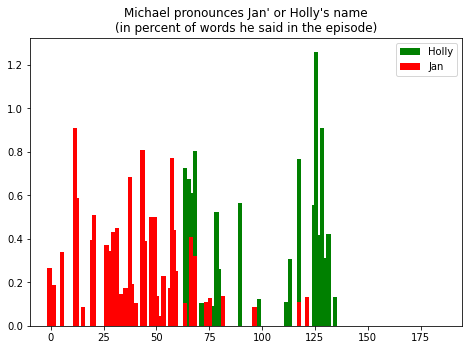

In [1264]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.bar(df.index,df.Michael_about_Jan + df.Michael_about_Holly,color='green')
ax.bar(df.index,df.Michael_about_Jan,color='red')

plt.title("Michael pronounces Jan' or Holly's name\n(in percent of words he said in the episode)")
plt.legend(['Holly','Jan'])
# change width of bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * 1)

change_width(ax, 2)

## Count dialogs
In schrute dataset there are only sequence of character's replica. I don't have scene descritption or timing of each replica. So, in searching for dialog I can only rely on sequence of replica. Here I will asuume that if character names alternate, this character talk to each other. I will count as dialog a set of at least 4 replicas of two characters where character's replica alternate. In my method of searching dialog I may count last replica of previous dialog as a first replica of following dialog, so, the error of number of replica in dialog would be +- 2 replicas.

In [1265]:
# create array of names in order of they appearance in script
def who_is_speaking(df, season, episode): 
    script_tmp = df[(df.season==season) & (df.episode==episode)]

    speaking = []
    for index in script_tmp.index:
        speaking.append(script_tmp[script_tmp.index==index].character.values[0])
        
    return speaking

In [1266]:
characters = list(characters)
characters[:20]

['Michael',
 'Dwight',
 'Jim',
 'Pam',
 'Andy',
 'Angela',
 'Kevin',
 'Erin',
 'Oscar',
 'Ryan',
 'Darryl',
 'Phyllis',
 'Kelly',
 'Toby',
 'Jan',
 'Stanley',
 'Meredith',
 'Holly',
 'Nellie',
 'Gabe']

here i will count number of dialog in each episode, mean length of dialogs in episode, length of dialog for main characters

In [1267]:
# create array with column's name
# create  empty column in database
characters_dialog = []
for name1 in characters:
    for name2 in characters[characters.index(name1)+1:]:
        names = np.sort([name1, name2])
        
        column_name = names[0] + '_' + names[1] + '_dialog'
        df[column_name] = 0
        characters_dialog.append(column_name)

df['dialog_mean_length'] = np.nan
df['number_of_dialog'] = np.nan

for season in range(1,10):
    episodes = np.sort(df[df.season==season].episode.unique())

    for episode in episodes: 
        # save all speakers
        speaking = who_is_speaking(script,season, episode)
        
        if len(speaking)==0:
            print('Error! Speaking is empty')
        
        dialog_length = []
        i = 0
        
        while i < len(speaking)- 1:
            names = np.unique(speaking[i:i+2])
            
            # count dialogs only for 20 most talkative characters
            if all([name in characters[:20] for name in names])==False:
                i += 1
                continue
                  
            # check that two different persons speak
            if len(names)==2:
                max_shift = len(speaking) - i
                
                # search for en of dialog
                for shift in range(2,max_shift):
                    new_names = np.unique(speaking[i:i+shift])
                    
                    #condition to stop search : new name appears
                    if any([name not in names for name in new_names]):
                        break
                
                dialog_length.append(shift-1)
                
                # save only dialog with 4 replicas
                if shift > 4:
                    names = np.sort(names)
                    key = names[0] + '_' + names[1] + '_dialog'
                    
                    df.loc[(df.season==season) & (df.episode==episode), [key]] += shift-1
                    

                
                i += shift - 1

            else:
                i += 1
        
        df.loc[(df.season==season) & (df.episode==episode), 'dialog_mean_length'] = np.mean(dialog_length)
        df.loc[(df.season==season) & (df.episode==episode), 'number_of_dialog'] = len(dialog_length)


normalisation of dialog number for double series

In [1268]:
df.loc[df.double == 1,['number_of_dialog']] = df[df.double == 1].number_of_dialog.apply(lambda x : x/2)

[Text(0.5, 1.0, 'Number of replicas in dialog (for all seasons)')]

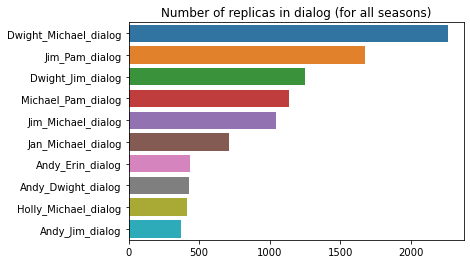

In [1269]:
df_tmp = df.sum()[characters_dialog].sort_values(ascending=False)[:10]
sns.barplot(y=df_tmp.index, x=df_tmp.values).set(title='Number of replicas in dialog (for all seasons)')

In [1270]:
df.sum()[characters_dialog].sort_values(ascending=False)[:10]

Dwight_Michael_dialog    2261
Jim_Pam_dialog           1677
Dwight_Jim_dialog        1247
Michael_Pam_dialog       1136
Jim_Michael_dialog       1041
Jan_Michael_dialog        712
Andy_Erin_dialog          438
Andy_Dwight_dialog        431
Holly_Michael_dialog      415
Andy_Jim_dialog           374
dtype: object

### Dialogs length and number

<AxesSubplot:xlabel='season', ylabel='dialog_mean_length'>

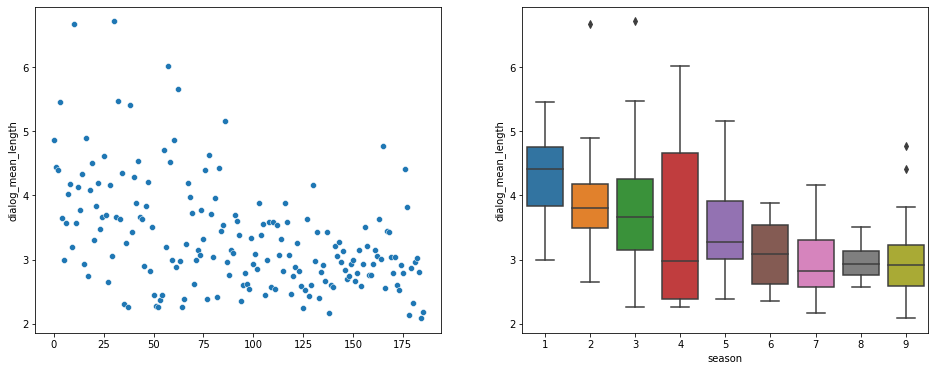

In [1271]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1, ncols=2)
sns.scatterplot(x=df.index, y=df.dialog_mean_length,ax=ax[0])
sns.boxplot(x=df.season, y=df.dialog_mean_length,ax=ax[1])

<AxesSubplot:xlabel='season', ylabel='number_of_dialog'>

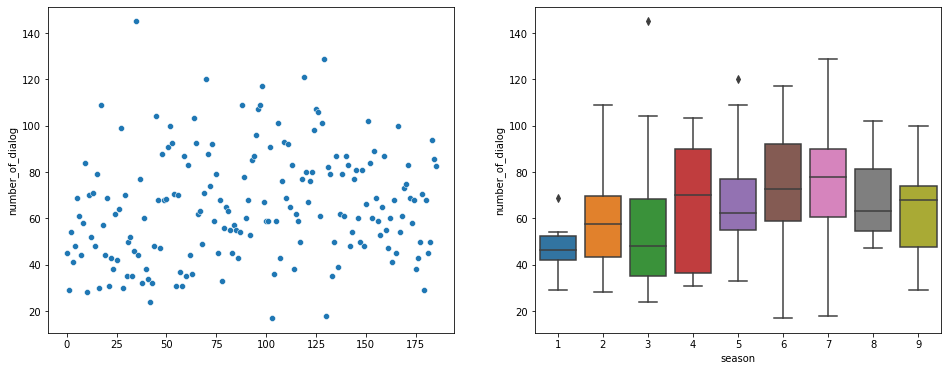

In [1272]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1, ncols=2)
sns.scatterplot(x=df.index, y=df.number_of_dialog,ax=ax[0])
sns.boxplot(x=df.season, y=df.number_of_dialog,ax=ax[1])

### Drop zero dialogs

In [1273]:
for name in characters_dialog:
    if df.sum()[name]==0:
        df.drop(columns=name,axis=1, inplace=True)

In [1274]:
characters_dialog_non_zero = []
for name in df.columns.values:
    if '_dialog' in name:
        characters_dialog_non_zero.append(name)

characters_dialog_non_zero.remove('number_of_dialog')

### Relationship between characters using dialog information

In [1275]:
import networkx as nx
import requests

import nxviz as nv
from nxviz import annotate

In [1276]:
groups = {'Michael': 1,'Dwight': 2,'Jim':2,'Pam':2,'Andy':2,
 'Angela':3,'Kevin':3,'Erin':3,'Oscar':3,'Ryan':3,'Darryl':3,
         'Phyllis':4,'Kelly':4,'Toby':4,'Jan':4,'Stanley':4,
         'Meredith':4,'Holly':4,'Nellie':4,'Gabe':4}

#### Only for Michael|

In [1277]:
P = nx.Graph()

arr = []
for name in characters[:1]:
    P.add_node(name)
    for cols in characters_dialog_non_zero:
        if name in cols:
            other_name = cols.replace(name,'').replace('_dialog','').replace('_',"")
            
            if other_name in characters[1:20]:
                P.add_edge(name, other_name, weight = df.sum()[cols])
                arr.append(df.sum()[cols])
                
# rescaling 2
for u,v in P.edges:
    P[u][v]['weight'] = P[u][v]['weight']/50
    P[u][v]["const"] = 1
    
for v in P:
    P.nodes[v]["name"] = v
    P.nodes[v]["size"] = 0.5
    P.nodes[v]["color"] = colors[v]
    P.nodes[v]["group"] = groups[v]

In [1278]:
# for node1, node2, data in P.edges(data=True):
#     print(node1, node2, data)

In [1279]:
# for node1,data in P.nodes(data=True):
#     print(node1, data)

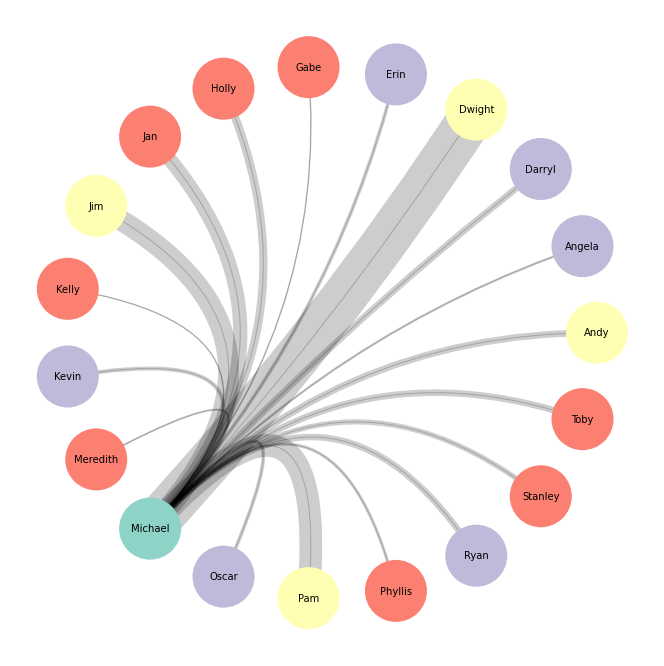

In [1280]:
fig, ax = plt.subplots(figsize=(12,12))

pos = nv.nodes.circos(P, group_by='name',size_by='size',color_by='group')
annotate.circos_labels(P, group_by='name')

nv.edges.circos(P, pos)  # or  nv.edges.line(P, pos)

# edge style
et = nv.utils.edge_table(P)

edge_color = nv.edges.edge_colors(et, nt=None, color_by=None, node_color_by=None)
alpha = nv.edges.transparency(et, alpha_by=None)

patches = nv.lines.circos( et, pos, edge_color=edge_color, alpha=alpha, lw=et["weight"], aes_kw={"fc": "none"} )
for patch in patches:
    ax.add_patch(patch)

nv.plots.rescale(P)
nv.plots.aspect_equal()
nv.plots.despine()

#### Without Michael

In [1281]:
P = nx.Graph()

arr = []
for name in characters[1:20]:
    P.add_node(name)
    for cols in characters_dialog_non_zero:
        if name in cols:
            other_name = cols.replace(name,'').replace('_dialog','').replace('_',"")
            
            if other_name in characters[1:20]:
                weight = df.sum()[cols]
                
                # treshold 
                if weight > 1677*0.05:
                    P.add_edge(name, other_name, weight=weight)
                    arr.append(df.sum()[cols])
                
# rescaling 2
for u,v in P.edges:
    P[u][v]['weight'] = P[u][v]['weight']/50
    P[u][v]["const"] = 1
#     P[u][v]["color"] = 'b'
    
for v in P:
#     print(v.)
    P.nodes[v]["name"] = v
    P.nodes[v]["size"] = 0.5
    P.nodes[v]["group"] = groups[v]

In [1282]:
max(arr)

1677

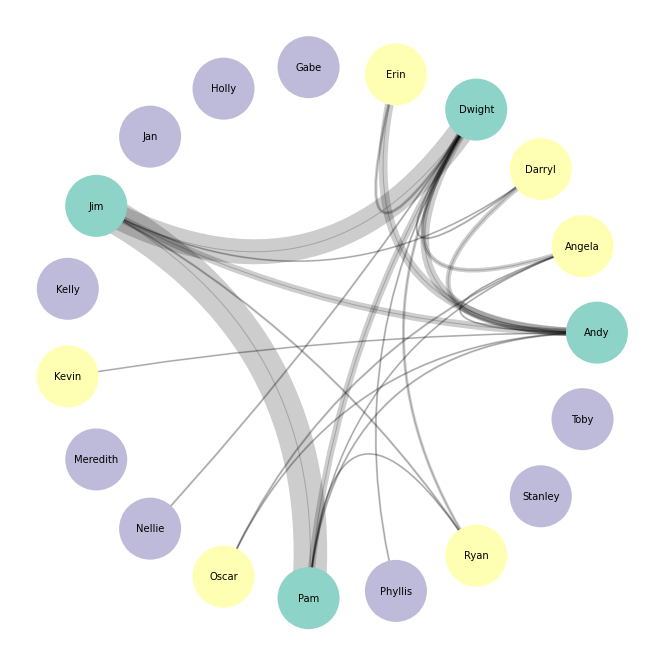

In [1283]:
fig, ax = plt.subplots(figsize=(12,12))

pos = nv.nodes.circos(P, group_by='name',size_by='size',color_by='group')
annotate.circos_labels(P, group_by='name')

nv.edges.circos(P, pos)  # or  nv.edges.line(P, pos)

# edge style
et = nv.utils.edge_table(P)

edge_color = nv.edges.edge_colors(et, nt=None, color_by=None, node_color_by=None)
alpha = nv.edges.transparency(et, alpha_by=None)

patches = nv.lines.circos( et, pos, edge_color=edge_color, alpha=alpha, lw=et["weight"], aes_kw={"fc": "none"} )
for patch in patches:
    ax.add_patch(patch)

nv.plots.rescale(P)
nv.plots.aspect_equal()
nv.plots.despine()

## Most rude / polite character
counting number of specific words character said, normilised by total number of words of the character. So, the numbers show how much of all that character speaks contains this word.    
Only for 20 most popular characters

In [1284]:
words_list = ['sorry','thank','all right','hell','shut up','bitch','slut','work','money','sales',
              'dunder','paper','love', 'michael','what she said']

In [1285]:
# create dataframe to save this results, since i will not use it in model
df_char_words = pd.DataFrame(index=characters)

df_char_words['words'] = np.nan
for person in characters[:20]:
    df_char_words.loc[df_char_words.index==person,'words'] = df[person + '_words'].sum()

In [1286]:
for word in words_list:
    df_char_words[word] = np.nan
    for person in characters[:20]:
        text_row = ' '.join( word for word in script[script.character==person].text)
        
        tot_words_for_person = df_char_words[df_char_words.index==person].words
        df_char_words.loc[df_char_words.index==person,[word]] = 100*text_row.lower().count(word)/tot_words_for_person

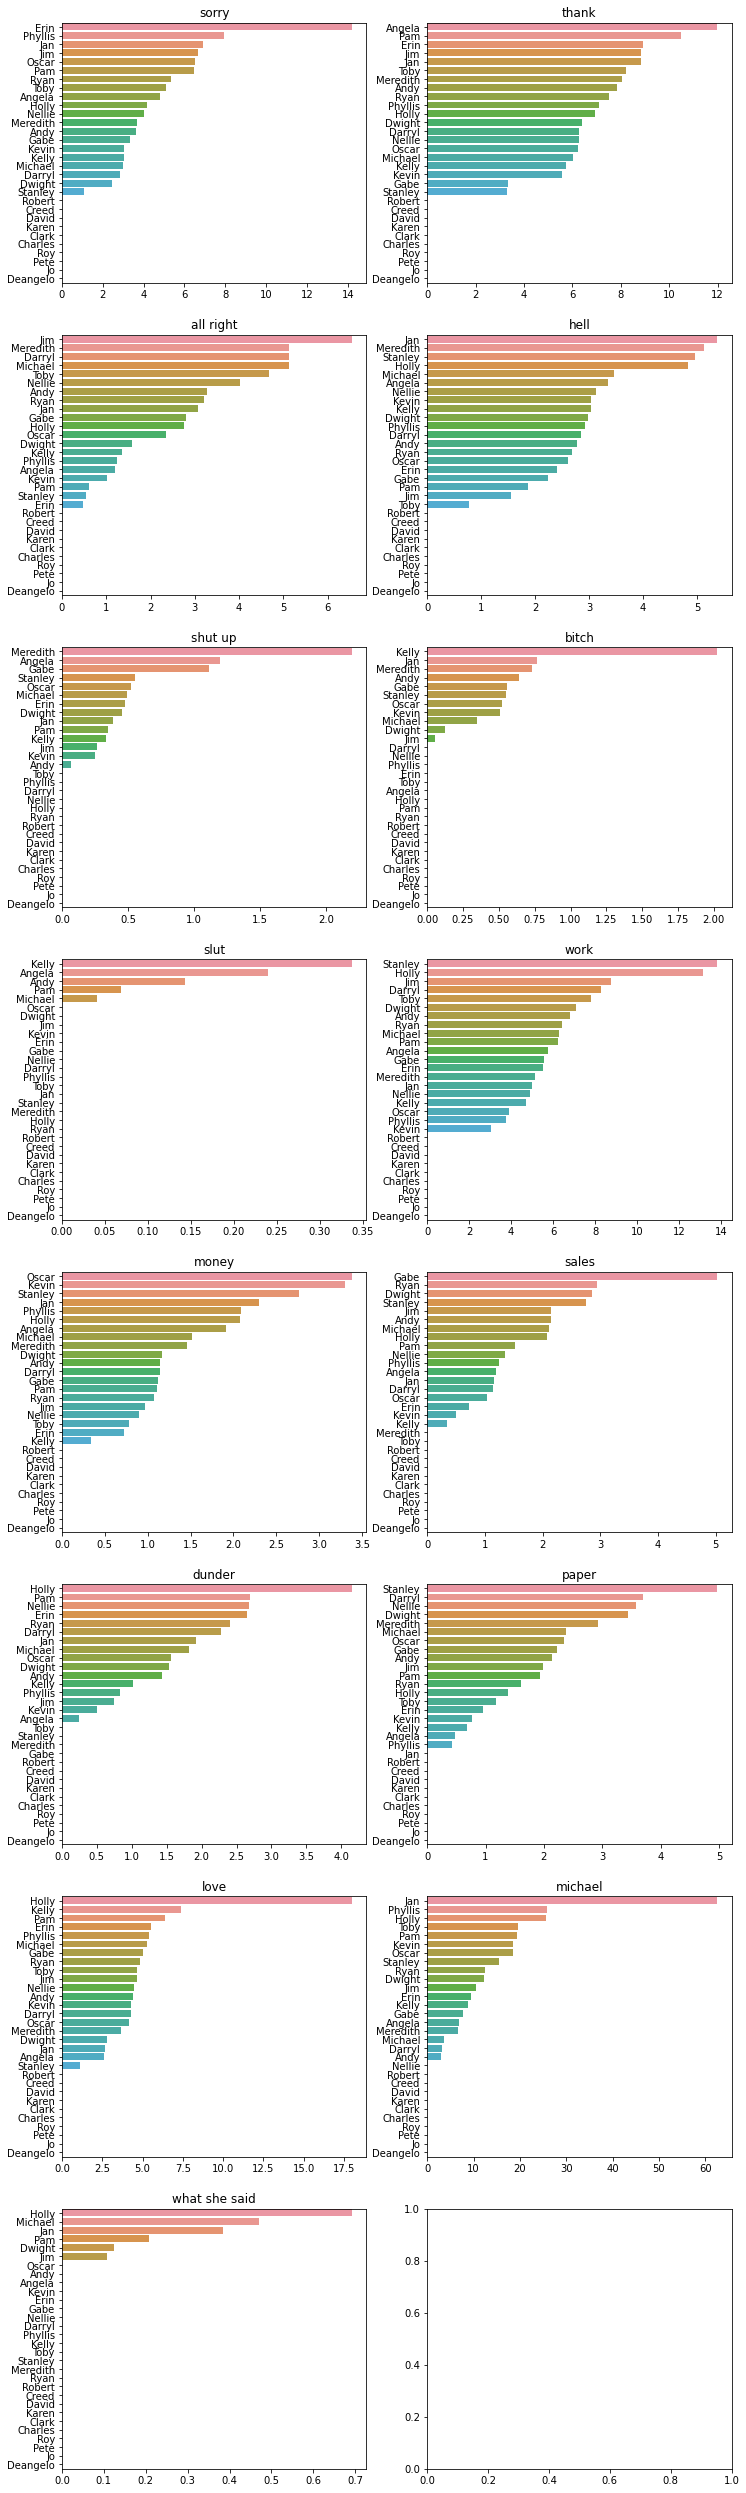

In [1287]:
words_n = len(words_list)

fig, ax = plt.subplots(figsize=(12,3*words_n),nrows=round(words_n/2), ncols=2)

k = 0
for word in words_list:
    stat = df_char_words[word].sort_values(ascending=False)
    sns.barplot(x=stat.values, y=stat.index, ax=ax[math.floor(k/2),k%2]).set(title=word)
    k += 1

## tf-idf for most popular characters

create dictionary with all words (except stop words) in all episodes

In [1288]:
all_words = {}

for word in bow_without_stop:
    if word not in all_words:
        all_words.update({word : 0})

for each word: calculate how much character said this word

In [1289]:
for name in characters[:20]:
    text_row = ' '.join( word for word in script[script.character==name].text)

    text = prepare_text(text_row, stop=True)

    for word in all_words:
        if word in text:
            all_words[word] += 1

In [1290]:
all_words['right']

20

In [1291]:
all_words['grasshopper']

1

it is possible that some words have zero appearance for main characters, should delete such words

In [1292]:
all_words_without_zero = {}

for word in all_words:
    if all_words[word] != 0:
        all_words_without_zero.update({word: all_words[word]})

calculate idf = np.log10(number of all characters/number of character who said this word)

In [1293]:
idf = {x: np.log10(20/y) for (x,y) in all_words_without_zero.items()}

In [1294]:
idf['right']

0.0

In [1295]:
idf['grasshopper']

1.3010299956639813

colormap for plot

In [1296]:
# import the desired colormap from matplotlib
cmap = mpl.cm.Blues(np.linspace(0,1,20)) 
# the darker part of the matrix is selected for readability
cmap = mpl.colors.ListedColormap(cmap[-10:,:-1])

calculating word frequency for each character and normilising it by idf

In [1297]:
from PIL import Image

In [1298]:
def plot_tfidf_word_cloud(names,mask=None, face=None):
    for name in names:
        text_row = ' '.join( word for word in script[script.character==name].text)

        text = prepare_text(text_row, stop=True)

        # counting each word appearance
        char_words = {}
        for word in text:
            if word in char_words:
                char_words[word] += 1
            else:
                char_words.update({word:1})
        
        
        # normilising each word by its idf
        for word in char_words:
            if word in idf:
                char_words[word] = char_words[word] * idf[word]
            else:
                print(f'"{word}" is not in idf dictionary')
        
        fig = plt.figure(figsize=(10,4))
        if mask is not None:
            cand_mask=np.array(Image.open(mask))
            cand_mask=np.where(cand_mask > 3, 255, cand_mask)
        else:
            cand_mask = None
            
        # plotting word cloud
        
        Cloud = WordCloud(background_color="white", max_words=20,prefer_horizontal=0.8,
                          mask=cand_mask,font_step=10,
                          colormap=cmap).generate_from_frequencies(char_words)

        plt.imshow(Cloud)
        plt.axis("off")
        
        if face is not None:
            plt.imshow(np.array(Image.open(face)))
        

        # print 5 most popular word 
        print('\n'+name)
        k = 0
        for word in sorted(char_words, key=char_words.get, reverse=True):
            print(word, round(char_words[word]))
            k += 1 
            if k > 5:
                break

    


Michael
jan 20
beep 17
phyllis 16
la 15
carol 15
holly 15


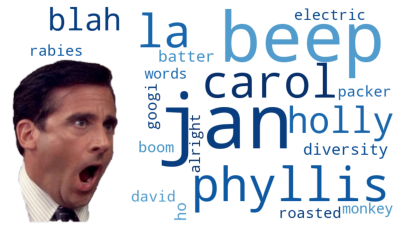

In [1299]:
plot_tfidf_word_cloud(['Michael'],mask="photos\Michael_black.png",face="photos\Michael_transparent.png")


Jim
rundown 12
assistant 11
warmer 9
halpert 8
nope 8
beesly 8


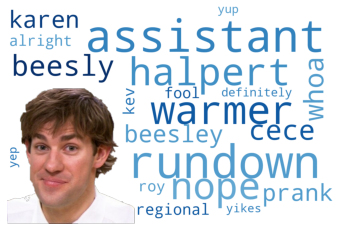

In [1300]:
plot_tfidf_word_cloud(['Jim'],mask="photos\Jim_black.png",face="photos\Jim_transp.png")


Jim
rundown 12
assistant 11
warmer 9
halpert 8
nope 8
beesly 8


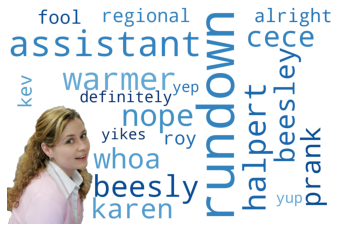

In [1301]:
plot_tfidf_word_cloud(['Jim'],mask="photos\Pam_black.png",face="photos\Pam_transp.png")


Dwight
schrute 41
mose 23
sensei 16
assistant 16
hay 14
ha 14


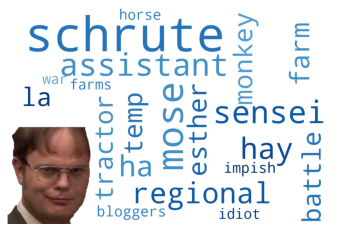

In [1302]:
plot_tfidf_word_cloud(['Dwight'],mask="photos\Dwight_black.png",face="photos\Dwight_transp.png")

## Count some of words appearance

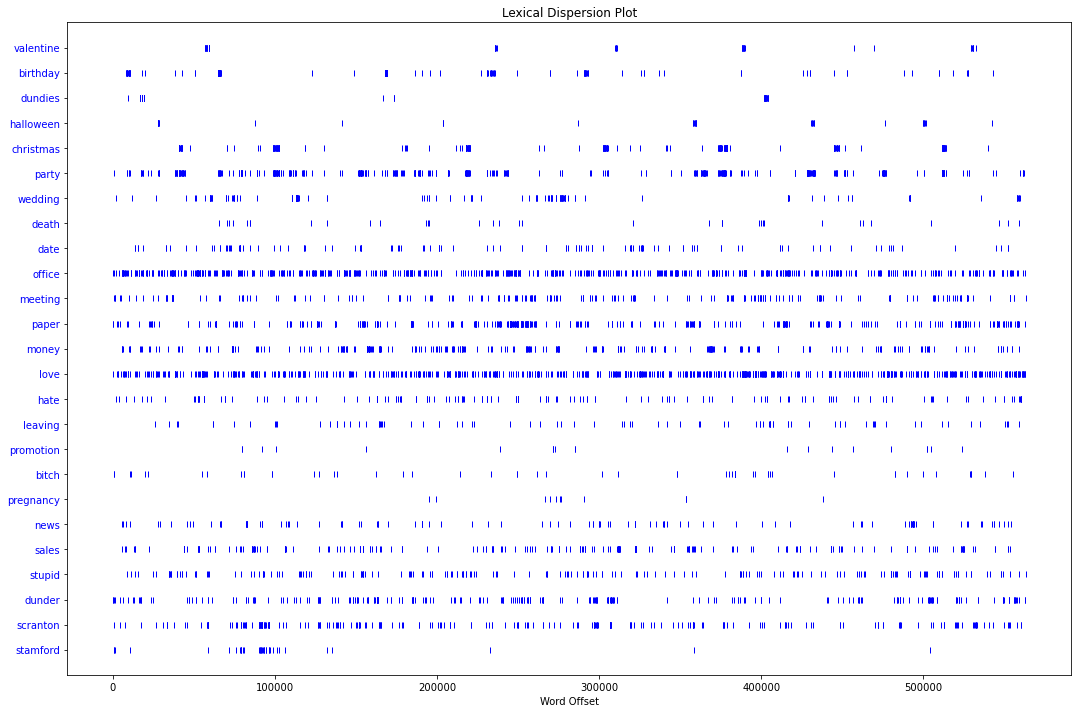

In [1303]:
intresting_words = ['valentine','birthday','dundies','halloween',
                    'christmas','party','wedding',
                    'death','date','office','meeting','paper','money','love','hate',
                    'leaving','promotion','bitch','pregnancy','news','sales','stupid',
                   'dunder','scranton','stamford' ]

plt.figure(figsize=(18,12))
dispersion_plot(bow_all,intresting_words,ignore_case=True)

In [1304]:
for word in intresting_words:
    df[word] = np.nan
    
for season in range(1,10):
    episodes = np.sort(df[df.season==season].episode.unique())

    for episode in episodes: 
        text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode)].text)

        text = prepare_text(text_row, stop=True)
        total_words = df[(df.season==season) & (df.episode==episode)].words
        
        for word in intresting_words:
            df.loc[(df.season==season) & (df.episode==episode),word] = 100 * text.count(word)/total_words

## Count "that's what she said"

In [1305]:
df['what_she_said'] = np.nan

for season in range(1,10):
    episodes = np.sort(df[df.season==season].episode.unique())

    for episode in episodes: 
        text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode)].text)
        text = text_row.lower()
        
        total_word = df[(df.season==season) & (df.episode==episode)].words
        df.loc[(df.season==season) & (df.episode==episode), ['what_she_said']] = 100 * text.count('what she said')/ total_word


[Text(0.5, 1.0, 'How much "thats what she said" appears'),
 Text(0.5, 0, 'episodes, running numeration'),
 Text(0, 0.5, 'number of appearance')]

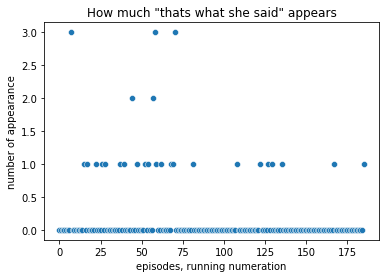

In [1306]:
sns.scatterplot(x=df.index, y=df.what_she_said * df.words/100).set(title='How much "thats what she said" appears',
                                                                  xlabel='episodes, running numeration',ylabel='number of appearance')

## Count director notes (action to play)

In [1307]:
text_row_w = ' '.join( word for word in script_w.text_w)

find all text in brackets

In [1308]:
words_in_brackets = re.findall("\[.*?\]",text_row_w.lower())

In [1309]:
in_brackets = []

for string in words_in_brackets:
    in_brackets.append(string)
    
df_brackets = pd.DataFrame(in_brackets)

In [1310]:
df_brackets[0].value_counts().sort_values(ascending=False)[:10]

[laughs]        301
[on phone]      154
[sighs]         126
[/b]            109
[singing]        98
[laughing]       82
[whispering]     78
[chuckles]       74
[whispers]       65
[to jim]         47
Name: 0, dtype: int64

In [1311]:
actions = {'laughing': ['laugh','giggl','chuckl'],
           'whispering':['whisper','murmur','mumbl'],
           'screaming':['scream','howl','yell'],
            'singing':['sing','whistl','chant'],
            'applause':['applause','clap'],
            'accent':['accent'],
            'crying':['cry','sobbing','groan'],
           'smiling':['smile','smiling'],
           'sigh':['sigh'],
           'kiss':['kiss']
          }

In [1312]:
for action in actions:
    df[action] = 0
    
for season in range(1,10):
    episodes = np.sort(df[df.season==season].episode.unique())

    for episode in episodes: 
        text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode)].text_w)
        text = text_row.lower()
        
        in_brackets = re.findall("\[.*?\]",text)
        
        for string in in_brackets:
            for action in actions:
                if  any( word in string for word in actions[action]):
                    df.loc[(df.season==season) & (df.episode==episode),action] += 1

In [1313]:
for action in actions.keys():
    print(action, df[action].sum())

laughing 862
whispering 234
screaming 72
singing 307
applause 150
accent 73
crying 121
smiling 99
sigh 164
kiss 116


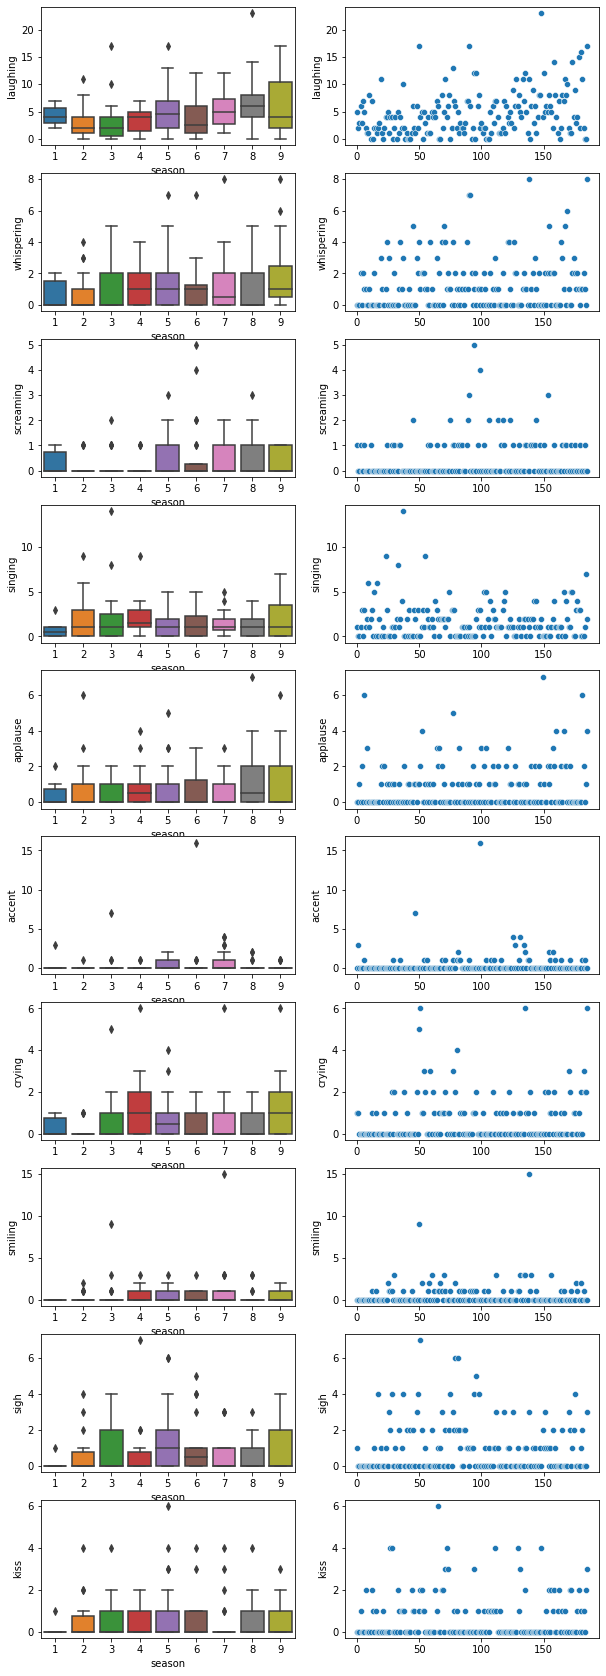

In [1314]:
fig,ax = plt.subplots(figsize=(10,30),nrows=len(actions.keys()), ncols=2)
i = 0
for action in actions.keys():
    sns.boxplot(x=df.season, y=df[action],ax=ax[i,0])
    sns.scatterplot(x=df.index, y=df[action],ax=ax[i,1])
    i += 1

# What influence rating the most?
<a class="anchor" id="third-bullet"></a>

making colun with 1 just for counting

In [1315]:
df['one']=1

[Text(0.5, 1.0, 'distribution of rating values')]

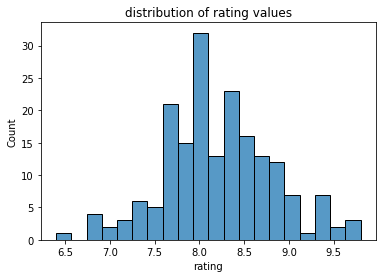

In [1316]:
sns.histplot(df.rating, bins=20).set(title='distribution of rating values')

In [1317]:
df.rating.mean()

8.211290322580647

In [1318]:
df.rating.median()

8.2

## number of votes 

<AxesSubplot:xlabel='votes', ylabel='rating'>

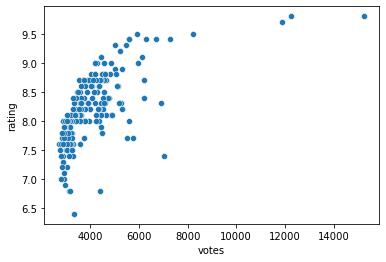

In [1319]:
sns.scatterplot(x=df.votes, y=df.rating)

## rating through the time

[Text(0.5, 0, 'episodes in order of appearance')]

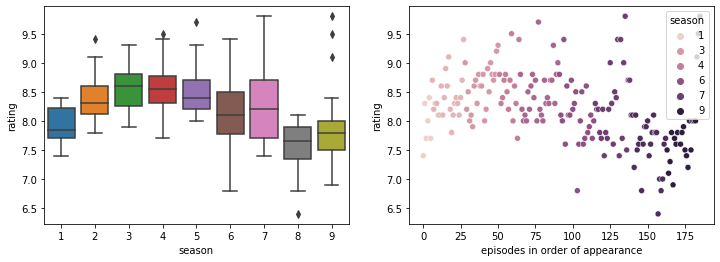

In [1320]:
fig, ax = plt.subplots(figsize=(12,4),nrows=1, ncols=2)

sns.boxplot(x=df.season, y=df.rating, ax=ax[0])
sns.scatterplot(x=df.index,y=df.rating,hue=df.season, ax=ax[1]).set(xlabel='episodes in order of appearance')

<AxesSubplot:xlabel='month', ylabel='rating'>

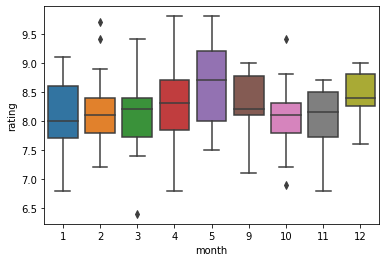

In [1321]:
sns.boxplot(x=df.month, y=df.rating)

## rating for double series

In [1322]:
df[df.double==1].rating.mean()

8.943750000000001

In [1323]:
df[df.double==0].rating.mean()

8.142352941176469

mean difference

In [1324]:
df[df.double==1].rating.mean() - df[df.double==0].rating.mean()

0.8013970588235324

median difference

In [1325]:
df[df.double==1].rating.median() - df[df.double==0].rating.median()

0.7000000000000011

weighted mean difference

In [1326]:
df[df.double==1].rating.mean()

8.943750000000001

there is a difference almost 1 score between double and regular episode

## rating vs number of words

<AxesSubplot:xlabel='words', ylabel='rating'>

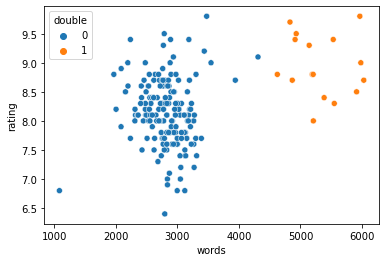

In [1327]:
sns.scatterplot(x=df.words,y=df.rating,hue=df.double)

In [1328]:
df.corr().rating.words

0.32017245212327006

In [1329]:
df[df.double==0].corr().rating.words

-0.00653641458058277

In [1330]:
df[df.double==1].corr().rating.words

-0.11642016231600685

rating stronly depends on episode's length(double or not), and this gives high correlation with words. But if we take only normal length episode, there is no coreelation.

## rating for different directors

In [1331]:
df_director = {}
for director in directors:
    df_director[director] = {'rating': df[df[director]==1].rating.mean(),'correl':df.corr().rating[director], 'num_of_episode':df[director].sum()}
    
df_director=pd.DataFrame(df_director).transpose()

In [1332]:
df_director[abs(df_director.correl) > 0.1].sort_values('correl',ascending=False)

,rating,correl,num_of_episode
director_Paul_Feig,8.700000,0.228710,14.0
director_Greg_Daniels,8.520000,0.149980,15.0
director_Harold_Ramis,8.825000,0.149242,4.0
director_Ken_Kwapis,8.525000,0.135138,12.0
director_Steve_Carell,8.833333,0.130644,3.0
director_Tucker_Gates,8.625000,0.100606,4.0
director_Rodman_Flender,7.600000,-0.104541,2.0
director_David_Rogers,7.877778,-0.123362,9.0
director_Ed_Helms,7.450000,-0.130194,2.0
director_Matt_Sohn,7.787500,-0.147374,8.0


episodes with Paul Feig as director have rating higher than average

In [1333]:
df[df['director_Paul_Feig']==1].rating.values

array([8.3, 8.1, 8.1, 8.4, 8.2, 9.5, 9.4, 8.8, 8.8, 8.4, 8.3, 8.3, 9.4,
       9.8])

In [1334]:
df[df.director_Greg_Daniels ==1].rating.values

array([8.4, 8.7, 8.6, 8.3, 8.4, 8.7, 9.4, 8.5, 8.6, 8.8, 8.8, 8. , 8.7,
       8.4, 7.5])

In [1335]:
df[df.director_Matt_Sohn==1].rating.values

array([8.6, 7.5, 7.7, 7.8, 7.8, 7.1, 7.8, 8. ])

It seems that viewers especially don't like episodes directed by Claire Scanlon

In [1336]:
df[df['director_Claire_Scanlon']==1].rating.values

array([6.8, 6.9])

## rating for different writers

In [1337]:
df_writer = {}
for writer in writers:
    df_writer[writer] = {'rating': df[df[writer]==1].rating.mean(),'correl':df.corr().rating[writer] ,'num_of_episode':df[writer].sum()}
    
df_writer=pd.DataFrame(df_writer).transpose()

In [1338]:
df_writer[abs(df_writer.correl) > 0.1].sort_values('correl',ascending=False)

,rating,correl,num_of_episode
writer_Greg_Daniels,8.725000,0.221293,12.0
writer_Paul_Lieberstein,8.531250,0.161015,16.0
writer_Michael_Schur,8.610000,0.155896,10.0
writer_Jennifer_Celotta,8.536364,0.133688,11.0
writer_Gene_Stupnitsky,8.460000,0.120830,15.0
writer_Lee_Eisenberg,8.460000,0.120830,15.0
writer_Steve_Carell,8.800000,0.100680,2.0
writer_Charlie_Grandy,7.912500,-0.103905,8.0
writer_Jonathan_Green,7.600000,-0.104541,2.0
writer_Gabe_Miller,7.600000,-0.104541,2.0


## Whose chatter people love most

In [1339]:
ordered_names = df.corr().rating[characters_words].sort_values(ascending=False).index

print('corr, appearance in episodes, name')
for name in ordered_names:
    print(round(df.corr().rating[name],2), df[df[name] != 0].sum().one, name)

corr, appearance in episodes, name
0.43 137 Michael_words
0.19 26 Karen_words
0.18 39 Jan_words
0.14 17 Holly_words
0.12 7 Charles_words
0.11 128 Creed_words
0.11 28 David_words
0.08 29 Roy_words
0.07 165 Stanley_words
0.07 170 Angela_words
0.06 165 Phyllis_words
0.05 185 Jim_words
0.02 140 Kelly_words
0.02 108 Toby_words
0.0 182 Pam_words
-0.01 130 Meredith_words
-0.02 139 Ryan_words
-0.07 8 Jo_words
-0.08 186 Dwight_words
-0.09 164 Oscar_words
-0.11 2 Deangelo_words
-0.13 179 Kevin_words
-0.15 22 Pete_words
-0.16 46 Gabe_words
-0.17 105 Darryl_words
-0.19 20 Clark_words
-0.3 21 Robert_words
-0.34 143 Andy_words
-0.36 98 Erin_words
-0.43 33 Nellie_words


## one person talking about the other vs rating

In [1340]:
cols_about = [word  for word in df.columns.values if '_about' in word]

In [1341]:
print('corr, episodes, feature')
oredered_names = df.corr().rating[cols_about].sort_values(ascending=False).index
for col in oredered_names:
    print(round(df.corr().rating[col],2), df[df[col] != 0].sum().one, col)

corr, episodes, feature
0.2 41 Michael_about_Jan
0.15 94 Jim_about_Pam
0.14 98 Jim_about_Dwight
0.11 24 Michael_about_Holly
0.06 76 Pam_about_Michael
-0.09 35 Pam_about_Jim


## rating vs dialog length

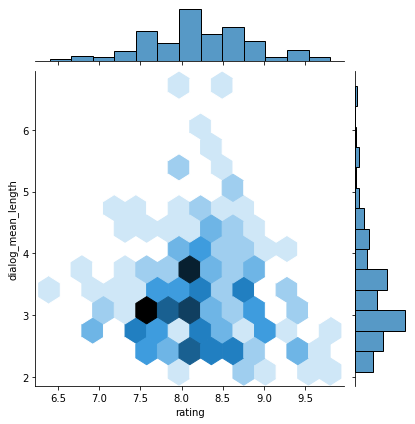

In [1342]:
sns.jointplot(x=df.rating, y=df.dialog_mean_length,kind='hex')

In [1343]:
df.corr().rating.dialog_mean_length

-0.04862171010913898

In [1344]:
df.corr().season.dialog_mean_length

-0.45190704518828007

## rating vs dialog number

<AxesSubplot:xlabel='rating', ylabel='number_of_dialog'>

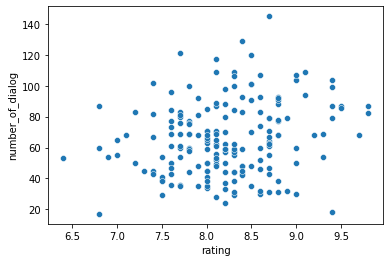

In [1345]:
sns.scatterplot(x=df.rating, y=df.number_of_dialog)

In [1346]:
df.corr().rating.number_of_dialog

0.19650458269202417

In [1347]:
df.corr().number_of_dialog.season

0.1852655051939569

## Whose dialogues have the most impact on the rating

update character dialog array

In [1348]:
characters_dialog_non_zero = []
for name in df.columns.values:
    if '_dialog' in name:
        characters_dialog_non_zero.append(name)

characters_dialog_non_zero.remove('number_of_dialog')

printing only dialogs with more than 100 replicas    
save most influencing rating dialogs

In [1349]:
ordered_names = df.corr().rating[characters_dialog_non_zero].sort_values(ascending=False).index

important_dialogs = []

print('corr, episodes, names')
for name in ordered_names:
    if df.sum()[name] > 100:
        print(round(df.corr().rating[name],2), df[df[name] != 0].sum().one, name)
        
        if abs(df.corr().rating[name]) > 0.1:
            important_dialogs.append(name)

corr, episodes, names
0.18 19 Angela_Michael_dialog
0.17 27 Jan_Michael_dialog
0.16 97 Dwight_Michael_dialog
0.16 27 Michael_Ryan_dialog
0.13 19 Michael_Phyllis_dialog
0.12 19 Darryl_Michael_dialog
0.12 71 Michael_Pam_dialog
0.12 15 Holly_Michael_dialog
0.12 28 Michael_Toby_dialog
0.11 63 Jim_Michael_dialog
0.11 33 Michael_Stanley_dialog
0.06 19 Michael_Oscar_dialog
0.05 27 Kevin_Michael_dialog
0.05 13 Dwight_Phyllis_dialog
0.04 30 Andy_Jim_dialog
0.03 23 Andy_Michael_dialog
0.0 11 Dwight_Ryan_dialog
-0.02 16 Erin_Michael_dialog
-0.02 22 Angela_Dwight_dialog
-0.02 13 Jim_Ryan_dialog
-0.04 29 Andy_Dwight_dialog
-0.05 9 Andy_Oscar_dialog
-0.09 79 Dwight_Jim_dialog
-0.1 33 Dwight_Pam_dialog
-0.1 10 Andy_Pam_dialog
-0.12 109 Jim_Pam_dialog
-0.14 13 Angela_Oscar_dialog
-0.17 8 Darryl_Dwight_dialog
-0.17 13 Dwight_Erin_dialog
-0.19 17 Andy_Darryl_dialog
-0.29 10 Dwight_Nellie_dialog
-0.3 35 Andy_Erin_dialog


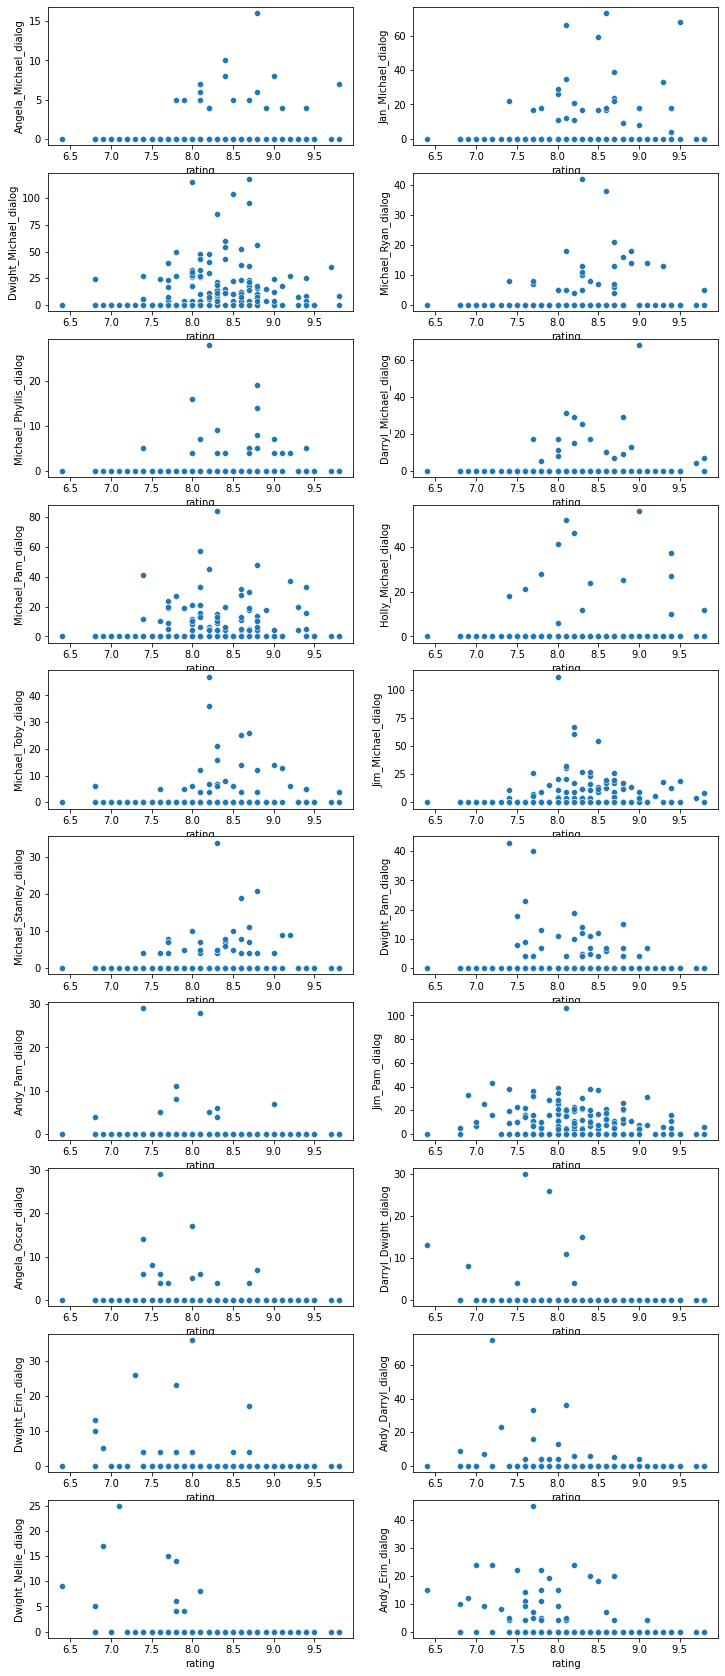

In [1350]:
fig, ax = plt.subplots(figsize=(12,30),nrows=round(len(important_dialogs)/2), ncols=2)

count = True
i = 0
for name in important_dialogs:
    if count:
        row = i
        count=False
    else:
        row = i
        i+= 1
        count = True
        
    sns.scatterplot(x=df.rating, y=df[name],ax=ax[row,int(count)])

## some word appearance vs rating

In [1351]:
word_rating = df.corr().rating[intresting_words].sort_values(ascending=False)
for word,val in zip(word_rating.index,word_rating.values):
    print(round(val,2), df[df[word]!=0].sum().one, word)

0.16 55 leaving
0.13 28 death
0.12 5 dundies
0.11 34 christmas
0.1 42 wedding
0.09 78 party
0.08 101 money
0.07 97 dunder
0.06 17 stamford
0.04 64 date
0.03 174 love
0.02 87 hate
0.01 114 paper
-0.0 9 pregnancy
-0.02 106 scranton
-0.03 166 office
-0.03 37 birthday
-0.04 7 valentine
-0.04 105 stupid
-0.06 15 promotion
-0.06 38 bitch
-0.1 91 sales
-0.11 95 meeting
-0.12 64 news
-0.13 10 halloween


In [1352]:
df.corr().rating.what_she_said

0.1493669949833294

##  Actions vs rating

In [1353]:
print('corr with rating | number of episodes | action')
action_rating = df.corr().rating[actions].sort_values(ascending=False)
for action,val in zip(action_rating.index,action_rating.values):
    print(round(val,2), df[df[action]!=0].sum().one, action)

corr with rating | number of episodes | action
0.32 70 crying
0.2 78 sigh
0.16 65 kiss
0.15 52 smiling
0.13 53 screaming
0.09 36 accent
0.09 102 whispering
0.04 125 singing
0.02 164 laughing
-0.01 78 applause


# Model to predict rating
<a class="anchor" id="fourth-bullet"></a>

features I can use for model:   

**episode properties**    
- writer     
- director    
- number of words told in episode    
- double or not    
- dialog mean length    
- number of dialog in episode    
- appearance of some words in the episode    
- "that's what she said" told   
- actions in writer notes

**Properties with character's name**   
- number of word each character said in the episode (in percent of total word in episode)   
- how much one character use the name of other character    
- number of dialog between characters   

In [1354]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.20)

<AxesSubplot:ylabel='rating'>

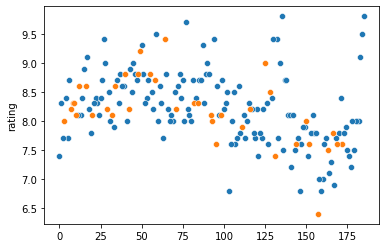

In [1355]:
sns.scatterplot(x=train.index,y=train.rating)
sns.scatterplot(x=test.index,y=test.rating)

[Text(0.5, 1.0, 'Test dataset')]

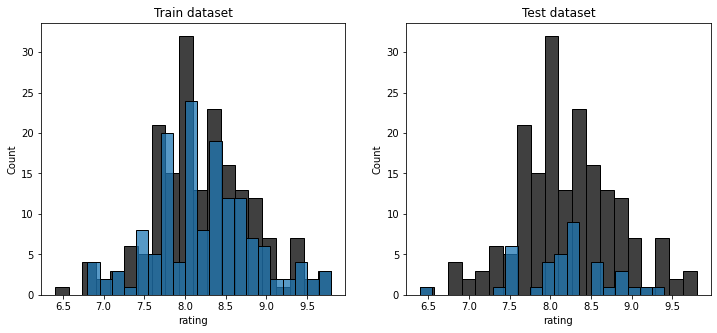

In [1356]:
fig, ax = plt.subplots(figsize=(12,5),nrows=1, ncols=2)
sns.histplot(df.rating,bins=20, ax=ax[0],color='black')
sns.histplot(train.rating,bins=20, ax=ax[0]).set(title='Train dataset')
sns.histplot(df.rating,bins=20, ax=ax[1],color='black')
sns.histplot(test.rating,bins=20, ax=ax[1]).set(title='Test dataset')

In [1357]:
def RMSE(y, y_pred):
    SME = sum((y - y_pred)**2)
    
    return round(math.sqrt(SME/len(y)),3)

## Linear regression model

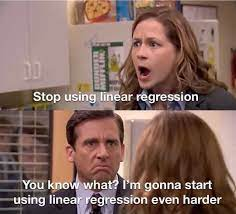

In [1358]:
import statsmodels.formula.api as smf

function to fit linear regression model

In [1384]:
 def linear_regression(train, test, model_features,weights=None):
    formula = 'rating ~ '

    for value in model_features:
        if value != 'rating':
            formula += value + " + "

    formula = formula[:-2]

    print(formula)
    print()
    
    if weights is not None:
        model = smf.ols(formula, data=train, weights=weights)
    else:
        model = smf.ols(formula, data=train)
        
    results = model.fit()
    
    print(results.summary())


    prediction = results.predict(test[model_features])

    fig,ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
    
    sns.scatterplot(x=test.rating.values, y=prediction.values, ax=ax[0]).set(title=f'RMSE={RMSE(test.rating.values, prediction.values)}')
    sns.kdeplot(prediction-test.rating,ax=ax[1]).set(title='KDE of residuals')
    sns.scatterplot(x=test.index, y=prediction-test.rating,ax=ax[2]).set(title='residuals across episodes')
    
    return results

### Choose features for model  with intuition

   



add properties, whih have high correlation with rating

In [1361]:
model_features = ['double','what_she_said']

add word whose appearance have high corr (abs value >= 0.1 ) with rating and with number of episodes where they appeared more than 60 (1/3 of all episodes)

In [1362]:
model_features += ['leaving', 'party','meeting','news']

the same criteria for action, but there is no action with high negative correlation

In [1363]:
model_features += ['crying','sigh','kiss']

choose director/writer with high correlation with rating (positive and negative) and who directed qiute a few episodes. There is a problem, that authors with high negative correlation work on only on few episodes.

In [1364]:
df.corr().director_Greg_Daniels.writer_Greg_Daniels

0.2437082168606182

In [1365]:
model_features += ['director_Paul_Feig','director_Ken_Kwapis','director_Matt_Sohn','director_Claire_Scanlon']

In [1366]:
model_features += ['writer_Greg_Daniels','writer_Paul_Lieberstein','writer_Charlie_Grandy','writer_Owen_Ellickson']

characters with high corr with rating

In [1367]:
characters_words_for_model = ['Michael_words','Creed_words',
                              'Darryl_words',
                              'Clark_words',
                              'Andy_words',
                              'Erin_words',
                              'Kevin_words']

In [1368]:
model_features += characters_words_for_model

In [1369]:
model_features += [ 'Dwight_Michael_dialog',
                   'Michael_Pam_dialog',
                   'Jim_Michael_dialog',
                   'Jim_Pam_dialog'
                    ]

In [1370]:
model_features += ['Jim_about_Pam', 'Jim_about_Dwight']

#### Check correlation between features

<AxesSubplot:>

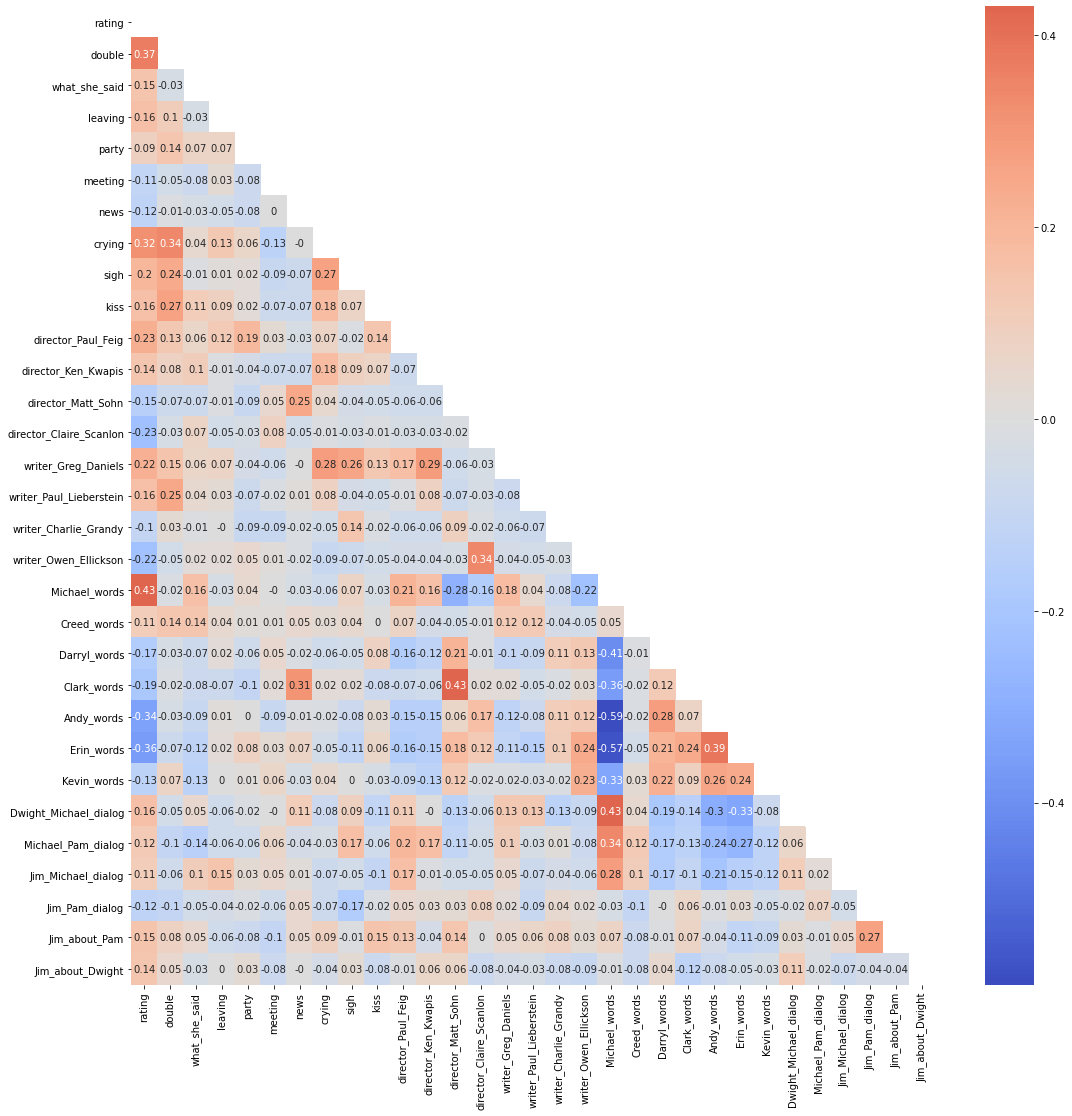

In [1371]:
corr = round(df[np.insert(model_features,0,'rating')].corr(),2)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(18,18))
sns.heatmap(corr, cmap='coolwarm', mask=mask, center=0,annot=True)


funny observations:    
Michael_about_Jan vs whar_she_said    
Clark_words - news    


#### Delete higly correlated  features (leave Michael_words)

In [1372]:
df[df.writer_Greg_Daniels ==1].director_Ken_Kwapis.mean()

0.3333333333333333

In [1373]:
df[df.writer_Owen_Ellickson == 1].director_Claire_Scanlon.mean()

0.25

In [1374]:
delete =  ['director_Matt_Sohn', 'director_Claire_Scanlon','writer_Greg_Daniels',
          'Darryl_words','Andy_words','Erin_words','Dwight_Michael_dialog','Michaeil_Pam_dialog',
          'Jim_Pam_dialog','Clark_words','Kevin_words','Michael_Pam_dialog','Jim_Michael_dialog',
           'writer_Paul_Lieberstein','writer_Owen_Ellickson']
model_features_1 = [word for word in model_features if word not in delete]

<AxesSubplot:>

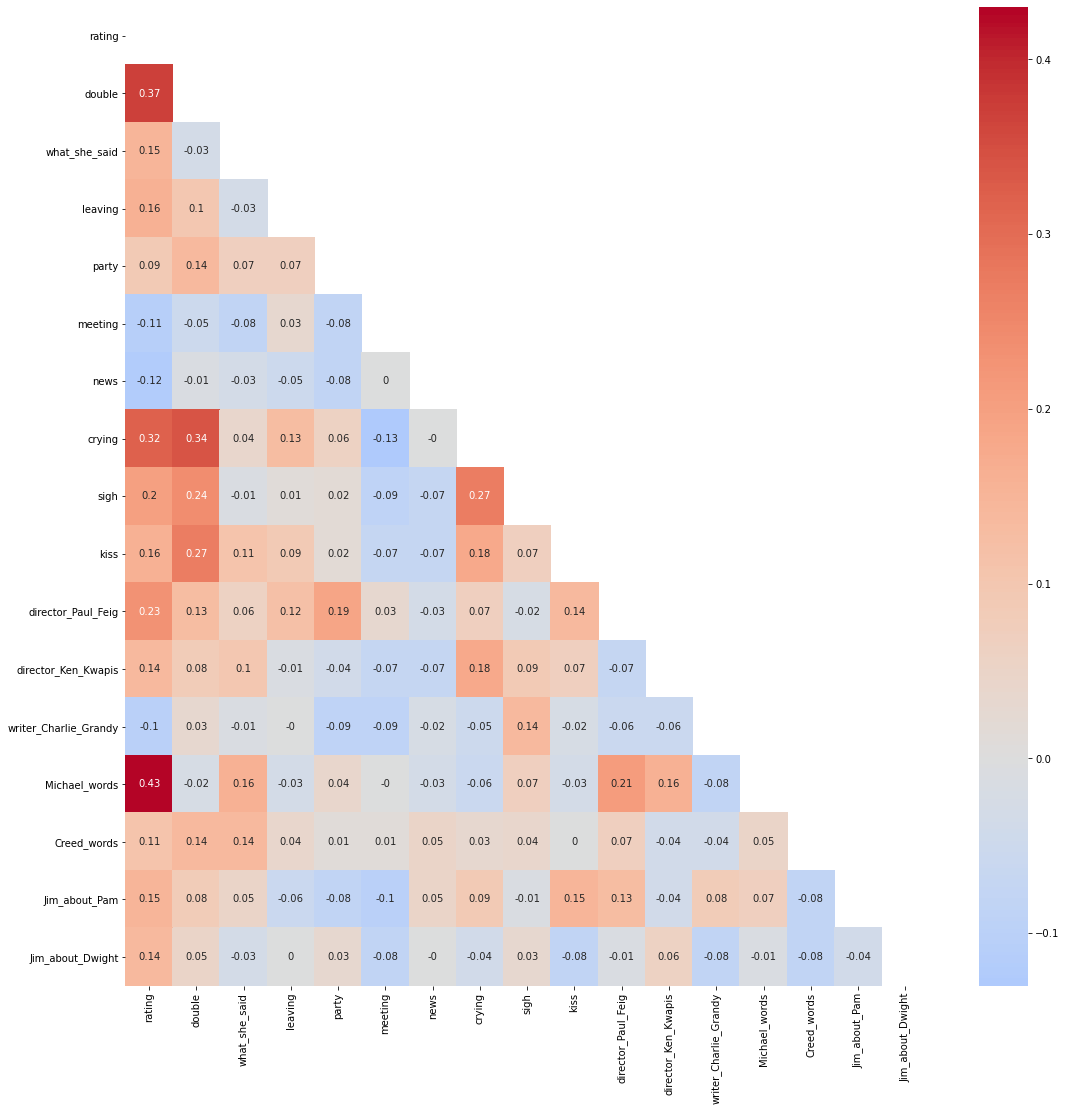

In [1375]:
corr = round(df[np.insert(model_features_1,0,'rating')].corr(),2)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(18,18))
sns.heatmap(corr, cmap='coolwarm', mask=mask, center=0,annot=True)

rating ~ double + what_she_said + leaving + party + meeting + news + crying + sigh + kiss + director_Paul_Feig + director_Ken_Kwapis + writer_Charlie_Grandy + Michael_words + Creed_words + Jim_about_Pam + Jim_about_Dwight 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     6.431
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           1.84e-10
Time:                        18:32:48   Log-Likelihood:                -97.117
No. Observations:                 148   AIC:                             228.2
Df Residuals:                     131   BIC:                             279.2
Df Model:                          16                                         
Covariance Type:            nonrobust                            

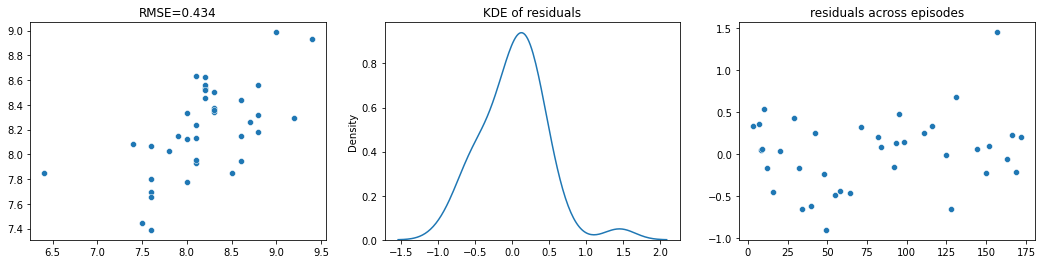

In [1376]:
linear_regression(train, test, model_features_1, weights=None)

delete high p and low-coeff features

In [1379]:
delete =  ['Creed_words','party','kiss','director_Ken_Kwapis','meeting','writer_Charlie_Grandy',
           'Jim_about_Pam','sigh','director_Paul_Feig']
model_features_2 = [word for word in model_features_1 if word not in delete]

rating ~ double + what_she_said + leaving + news + crying + Michael_words + Jim_about_Dwight 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.734e+05
Date:                Mon, 20 Dec 2021   Prob (F-statistic):          2.82e-272
Time:                        18:35:51   Log-Likelihood:                -100.94
No. Observations:                 148   AIC:                             217.9
Df Residuals:                     140   BIC:                             241.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

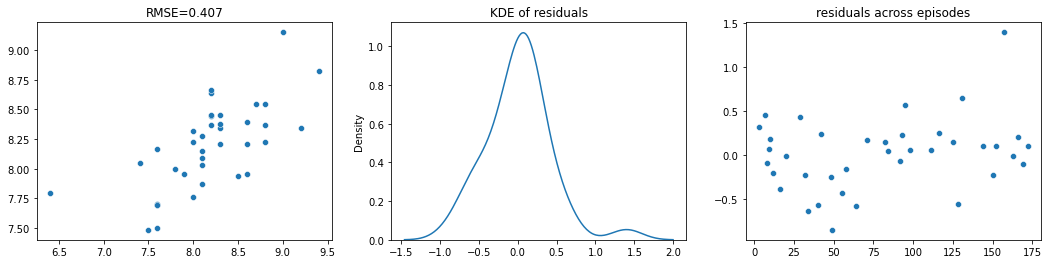

In [1386]:
res = linear_regression(train, test, model_features_2, weights=train.votes)

In [1394]:
res.params.sort_values(ascending=False)

Intercept           7.621225
what_she_said       3.343508
leaving             2.188352
double              0.573698
Jim_about_Dwight    0.174452
crying              0.129362
Michael_words       0.013995
news               -1.791142
dtype: float64

#### Delete higly correlated  features (delete Michael_words)

In [1395]:
delete =  ['Michael_words','Andy_words','director_Matt_Sohn', 'director_Claire_Scanlon','writer_Greg_Daniels',
          'Dwight_Michael_dialog','Jim_about_Pam','Michael_Pam_dialog',
          'news']
model_features_11 = [word for word in model_features if word not in delete]

<AxesSubplot:>

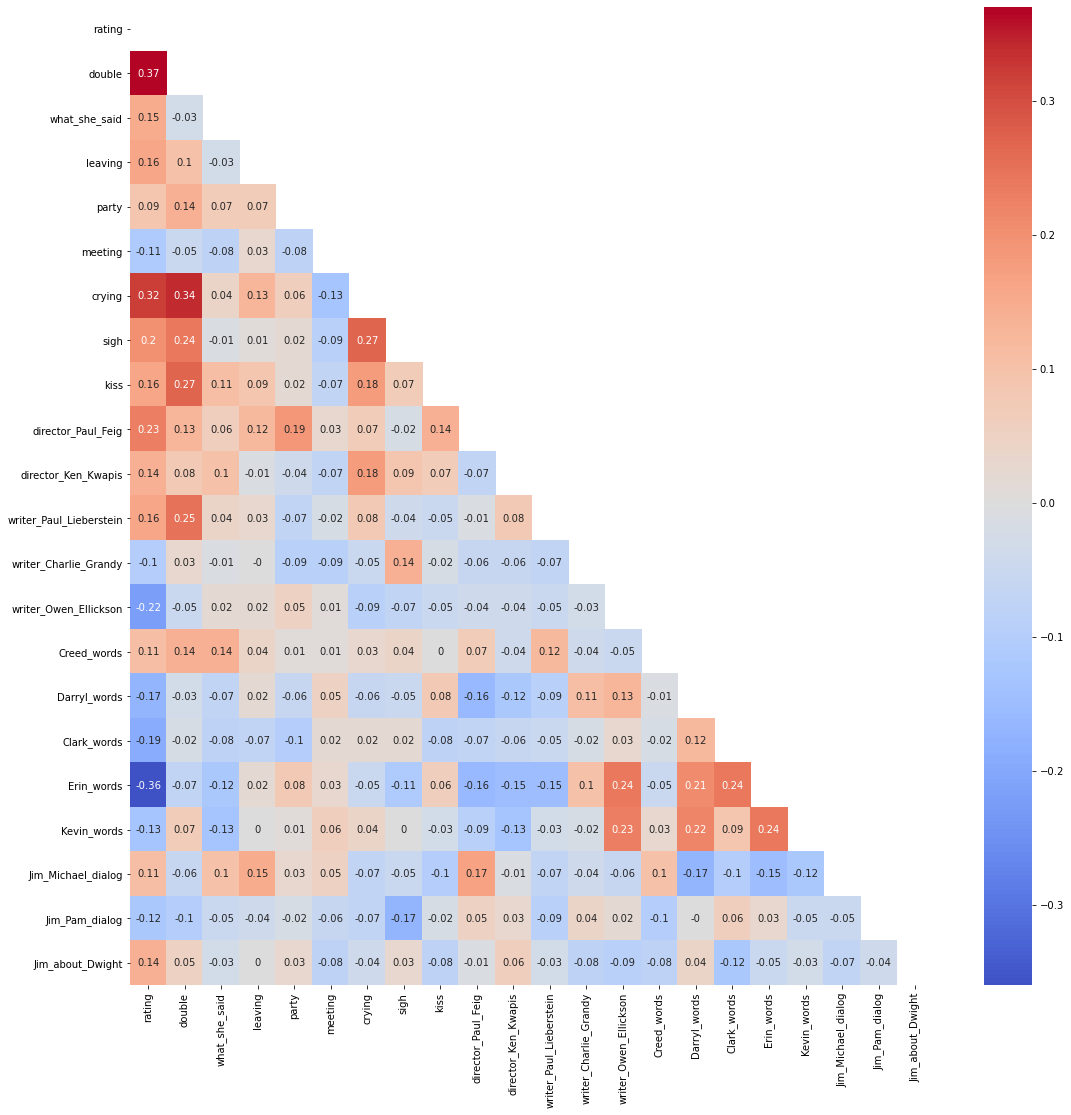

In [1396]:
corr = round(df[np.insert(model_features_11,0,'rating')].corr(),2)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(18,18))
sns.heatmap(corr, cmap='coolwarm', mask=mask, center=0,annot=True)


rating ~ double + what_she_said + leaving + party + meeting + crying + sigh + kiss + director_Paul_Feig + director_Ken_Kwapis + writer_Paul_Lieberstein + writer_Charlie_Grandy + writer_Owen_Ellickson + Creed_words + Darryl_words + Clark_words + Erin_words + Kevin_words + Jim_Michael_dialog + Jim_Pam_dialog + Jim_about_Dwight 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     3.979
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           5.74e-07
Time:                        18:37:35   Log-Likelihood:                -102.37
No. Observations:                 148   AIC:                             248.7
Df Residuals:                     126   BIC:                             314.7
Df Model:                          21  

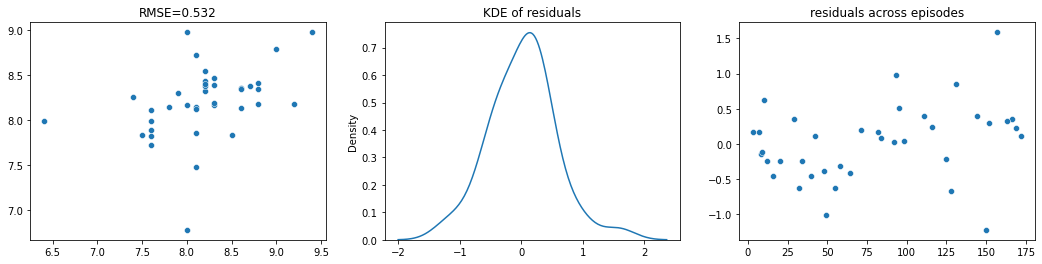

In [1397]:
linear_regression(train, test, model_features_11, weights=None)

In [1404]:
delete =  ['kiss','Darryl_words','Kevin_words','Creed_words','Clark_words','Jim_Pam_dialog','party','meeting',
           'writer_Charlie_Grandy','director_Ken_Kwapis','writer_Paul_Lieberstein',
           'sigh','Jim_Michael_dialog']
model_features_21 = [word for word in model_features_11 if word not in delete]

rating ~ double + what_she_said + leaving + crying + director_Paul_Feig + writer_Owen_Ellickson + Erin_words + Jim_about_Dwight 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     9.637
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           1.44e-10
Time:                        18:40:22   Log-Likelihood:                -107.36
No. Observations:                 148   AIC:                             232.7
Df Residuals:                     139   BIC:                             259.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025   

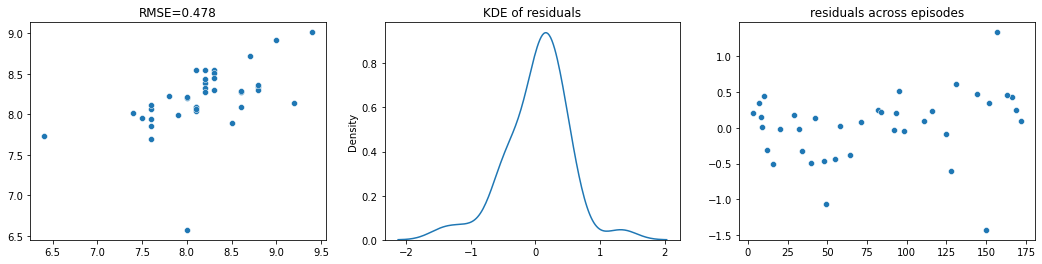

In [1408]:
res = linear_regression(train, test, model_features_21, weights=None)

In [1409]:
res.params.sort_values(ascending=False)

Intercept                8.087380
what_she_said            4.610981
leaving                  1.708565
double                   0.509450
director_Paul_Feig       0.328651
Jim_about_Dwight         0.137163
crying                   0.097203
Erin_words              -0.044300
writer_Owen_Ellickson   -0.856090
dtype: float64

## Choose features using scikit instruments

select all features

In [1410]:
all_features = df.columns.values
len(all_features)

343

remove target feature and character words (they are dublicated in character words_total)

In [1411]:
all_features  = [col for col in all_features if col not in ['season', 'title', 'rating', 'votes', 'episode','votes_norm','month'] ]

In [1412]:
all_features = [word for word in all_features if word not in characters_words_total]
len(all_features)

306

###  keep features, which appears more than in half episodes

number of episodes with low rating

In [1413]:
len(df[df.rating < df.rating.mean()])

102

In [1414]:
delete = []
for col in all_features:
    appearance = df[df[col] != 0].sum().one
    
    if appearance < 60:
        delete.append(col)


In [1415]:
len(delete)

257

In [1416]:
model_features_1 = [word for word in all_features if word not in delete]
len(model_features_1)

49

### delete features with low variance

In [1417]:
from sklearn.feature_selection import VarianceThreshold

In [1418]:
normalized_df = df[model_features_1] / df[model_features_1].mean()

In [1419]:
normalized_df.var().sort_values(ascending=True)[:10]

one                   0.000000
dialog_mean_length    0.064275
words                 0.069214
number_of_dialog      0.130342
Jim_words             0.221258
Dwight_words          0.280645
Pam_words             0.302153
Michael_words         0.453363
love                  0.602221
office                0.692910
dtype: float64

In [1420]:
vt = VarianceThreshold(threshold=.1)

_ = vt.fit(normalized_df)
mask = vt.get_support()

In [1421]:
df_for_model = df[model_features_1]
df_for_model = df_for_model.loc[:,mask]

In [1422]:
model_features_2 = df_for_model.columns.values

what was deleted

In [1423]:
[word for word in model_features_1 if word not in model_features_2 ]

['words', 'dialog_mean_length', 'one']

In [1424]:
len(model_features_2)

46

In [1425]:
model_features_2

array(['Michael_words', 'Dwight_words', 'Jim_words', 'Pam_words',
       'Andy_words', 'Angela_words', 'Kevin_words', 'Erin_words',
       'Oscar_words', 'Ryan_words', 'Darryl_words', 'Phyllis_words',
       'Kelly_words', 'Toby_words', 'Stanley_words', 'Meredith_words',
       'Creed_words', 'Jim_about_Pam', 'Jim_about_Dwight',
       'Pam_about_Michael', 'Dwight_Michael_dialog', 'Jim_Michael_dialog',
       'Michael_Pam_dialog', 'Dwight_Jim_dialog', 'Jim_Pam_dialog',
       'number_of_dialog', 'scranton', 'dunder', 'stupid', 'sales',
       'news', 'hate', 'love', 'money', 'paper', 'meeting', 'office',
       'date', 'party', 'laughing', 'whispering', 'singing', 'applause',
       'crying', 'sigh', 'kiss'], dtype=object)

### backward elimination

In [1426]:
def backward_elimination(train, features, treshold=0.05):
    max_p = 1
    
    while max_p > treshold:
#         print()
#         print(len(features), max_p)
        
        formula = 'rating ~ '
        for value in features:
            formula += value + " + "
        
        formula = formula[:-2]

        
        model = smf.ols(formula, data=train)
        results = model.fit()
        
        max_p = max(results.pvalues)
        
        if max_p > treshold:
            
            delete = []
            for col in features:
                if abs(results.pvalues[col] - max_p) <= 0.0000001:
                    delete.append(col)
                    
            features = [word for word in features if word not in delete]

        if len(features) == 0:
            break

    return features
    

In [1427]:
new_features = backward_elimination(train, model_features_2, treshold=0.1)
new_features

['Michael_words',
 'Jim_words',
 'Jim_about_Dwight',
 'Jim_Pam_dialog',
 'number_of_dialog',
 'crying',
 'kiss']

rating ~ Michael_words + Jim_words + Jim_about_Dwight + Jim_Pam_dialog + number_of_dialog + crying + kiss 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     14.17
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           7.95e-14
Time:                        18:42:21   Log-Likelihood:                -100.38
No. Observations:                 148   AIC:                             216.8
Df Residuals:                     140   BIC:                             240.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------

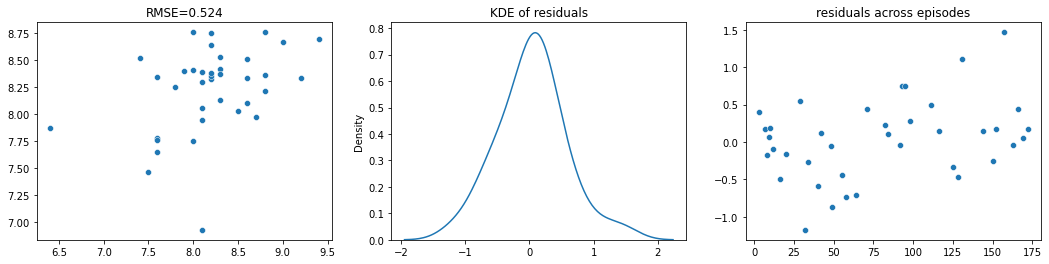

In [1429]:
res = linear_regression(train, test, new_features)

In [1430]:
res.params.sort_values(ascending=False)

Intercept           7.185807
crying              0.156412
Jim_about_Dwight    0.151753
kiss                0.094656
Jim_words           0.018429
Michael_words       0.015628
number_of_dialog    0.004502
Jim_Pam_dialog     -0.009353
dtype: float64

### Lasso

In [1431]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [1484]:
lasso = LassoCV().fit(train[model_features_2], train.rating)
importance = np.abs(lasso.coef_)

In [1485]:
lasso_coef = {}
for feature, coef in zip(model_features_2, lasso.coef_):
    if coef != 0:
        lasso_coef.update({feature: [coef]})
        
lasso_coef = pd.DataFrame.from_dict(lasso_coef).transpose()

In [1486]:
lasso_coef.sort_values(0,ascending=False)

,0
crying,0.092702
kiss,0.029497
Michael_words,0.011604
Jim_words,0.009945
number_of_dialog,0.006519
Dwight_words,0.002622
laughing,0.000935
Michael_Pam_dialog,-0.000148
Dwight_Michael_dialog,-0.000166
Dwight_Jim_dialog,-0.000685


In [1547]:
# for index in lasso_coef.sort_values(0,ascending=False).index:
#     print(index, round(lasso_coef[lasso_coef.index==index][0].values[0],3))

In [1482]:
prediction = lasso.predict(test[model_features_2])

[Text(0.5, 1.0, 'residuals across episodes')]

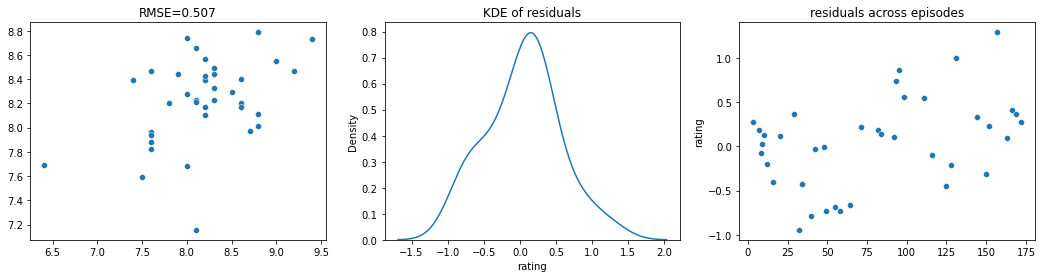

In [1495]:
fig,ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
    
sns.scatterplot(x=test.rating.values, y=prediction, ax=ax[0]).set(title=f'RMSE={RMSE(test.rating.values, prediction)}')
sns.kdeplot(prediction-test.rating,ax=ax[1]).set(title='KDE of residuals')
sns.scatterplot(x=test.index, y=prediction-test.rating,ax=ax[2]).set(title='residuals across episodes')

## Random forest tree

In [1496]:
from sklearn.ensemble import RandomForestRegressor

In [1497]:
to_drop = ['rating','title','season','episode','votes','votes_norm'] + characters_words_total

In [1498]:
x_train = train.drop(columns=to_drop,axis=1)

In [1499]:
x_test = test.drop(columns=to_drop,axis=1)


choose best parameters for random tree

In [1505]:
n_trees = [10, 50, 100, 500, 1000]
n_features = [30,60,90,120]

to_print= {}
ordered_rmse = []

for tr in n_trees:
    for ft in n_features:
        dtree = RandomForestRegressor(max_features=ft, n_estimators=tr)
        dtree.fit(x_train, train.rating, sample_weight=train.votes_norm)

        prediction = dtree.predict(x_test)
        rmse = RMSE(test.rating.values, prediction)
        if rmse not in to_print:
            to_print.update({rmse: [tr, ft]})
            ordered_rmse.append(rmse)

print('RMSE [num of estimator, max features]')
for val in np.sort(ordered_rmse):
    print(val, to_print[val] )

RMS [num of estimator, max features]
0.398 [50, 120]
0.401 [500, 90]
0.403 [1000, 120]
0.404 [500, 60]
0.405 [500, 120]
0.406 [1000, 90]
0.408 [100, 120]
0.411 [50, 30]
0.413 [50, 60]
0.414 [1000, 60]
0.419 [1000, 30]
0.42 [100, 30]
0.423 [500, 30]
0.424 [50, 90]
0.439 [100, 60]
0.44 [10, 90]
0.447 [10, 60]
0.5 [10, 30]
0.511 [10, 120]


[Text(0.5, 1.0, 'RMSE=0.407')]

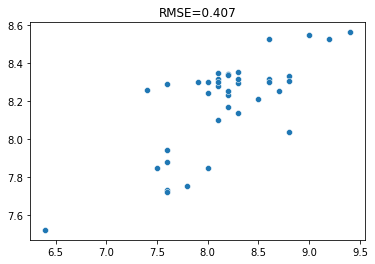

In [1509]:
dtree = RandomForestRegressor(max_features=90, n_estimators=50)
dtree.fit(x_train, train.rating, sample_weight=train.votes_norm)

prediction = dtree.predict(x_test)

sns.scatterplot(x=test.rating.values, y=prediction).set(title=f"RMSE={RMSE(test.rating.values, prediction)}")

<AxesSubplot:ylabel='Density'>

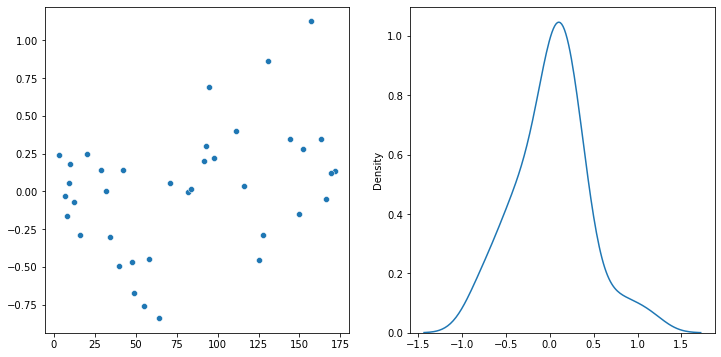

In [1510]:
residuals = prediction-test.rating.values

fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
sns.scatterplot(x=test.index, y=residuals,ax=ax[0])
sns.kdeplot(residuals, ax=ax[1])

<AxesSubplot:xlabel='Importance', ylabel='Variable'>

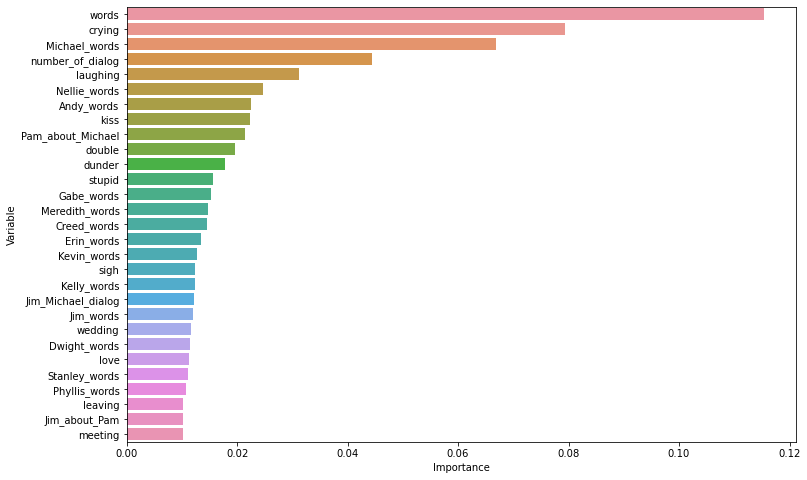

In [1511]:
importance = pd.DataFrame({'Variable':x_train.columns,
              'Importance':dtree.feature_importances_}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=importance[importance.Importance > 0.01].Importance, y=importance[importance.Importance > 0.01].Variable)

In [1527]:
# for index in importance.index[:10]:
#     print(importance[importance.index==index].Variable.values[0], round(importance[importance.index==index].Importance.values[0],2))

### Linear regression model with features selected by random tree 

In [1538]:
features_tree = importance[:6].Variable.values

rating ~ words + crying + Michael_words + number_of_dialog + laughing + Nellie_words 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     16.26
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           3.57e-14
Time:                        19:14:15   Log-Likelihood:                -101.10
No. Observations:                 148   AIC:                             216.2
Df Residuals:                     141   BIC:                             237.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

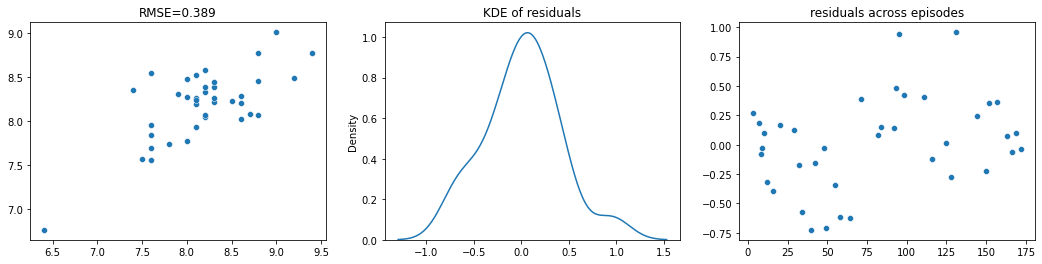

In [1540]:
res = linear_regression(train, test, features_tree)

In [1541]:
res.params.sort_values(ascending=False)

Intercept           7.112287
crying              0.145955
Michael_words       0.011911
number_of_dialog    0.003310
laughing            0.000463
words               0.000173
Nellie_words       -0.041091
dtype: float64

<AxesSubplot:xlabel='rating'>

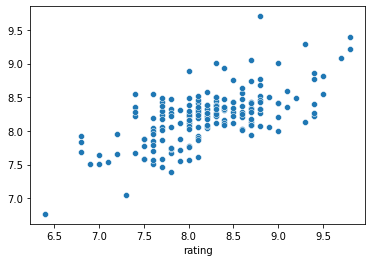

In [1546]:
sns.scatterplot(x=df.rating,y=res.predict(df[features_tree]))